# Zero-Adjusted Gamma Regression

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/docs/examples/ZAGamma_Regression.ipynb)

# Imports

In [1]:
# !pip install xgboost~=1.7.6
# !pip install plotnine~=0.12.1
# !pip install pyro-ppl~=1.8.5
# !pip install optuna~=3.2.0
# !pip install shap
# !pip install properscoring~=0.1
# !pip install torch~=2.0.1

In [18]:
import os

# # Define the path to the directory you want to move to

print("Current Working Directory:", os.getcwd())
os.chdir('../../xgboostlss')
print("Current Working Directory:", os.getcwd())



Current Working Directory: /Users/linyang1024/Documents/GitHub/XGBoostLSS/docs/examples
Current Working Directory: /Users/linyang1024/Documents/GitHub/XGBoostLSS/xgboostlss


In [19]:
os.chdir('../../xgboostlss')
from xgboostlss.model import *
from xgboostlss.distributions.ZAGamma import *

from sklearn.model_selection import train_test_split 
import pandas as pd
import multiprocessing
import plotnine
from plotnine import *
plotnine.options.figure_size = (18, 9)
n_cpu = multiprocessing.cpu_count()

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [ ]:
# The simulation example closely follows https://towardsdatascience.com/zero-inflated-regression-c7dfc656d8af
np.random.seed(123)
n_samples = 1000

data = pd.DataFrame({"age": np.random.randint(1, 100, size=n_samples)})
data["income"] = np.where((data.age > 17) & (data.age < 70), 1500*data.age + 5000 + 10000*np.random.randn(n_samples), 0) / 1000

y = data["income"].values.reshape(-1,1) 
X = data.drop(columns="income")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution Selection

In [ ]:
# Specifies Zero-Adjusted Gamma distribution. See ?ZAGamma for an overview.
xgblss = XGBoostLSS(
    ZAGamma(stabilization="None",        # Options are "None", "MAD", "L2".
            response_fn="exp",           # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
            loss_fn="nll"                # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).)      
           )           
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are specified, max_depth is not used when gblinear is sampled, since it has no such argument.

In [ ]:
param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-09-21 15:15:02,091] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization
Best trial: 0. Best value: 446.001:    1%|          | 00:01/05:00

[I 2023-09-21 15:15:03,700] Trial 0 finished with value: 446.00059819999996 and parameters: {'eta': 0.00280650953971745, 'max_depth': 4, 'gamma': 0.00038241632918277176, 'subsample': 0.31160435629028793, 'colsample_bytree': 0.6736951853210107, 'booster': 'gbtree'}. Best is trial 0 with value: 446.00059819999996.


Best trial: 0. Best value: 446.001:    1%|          | 00:02/05:00

[I 2023-09-21 15:15:05,086] Trial 1 finished with value: 503.5875244 and parameters: {'eta': 1.311953756950869e-05, 'max_depth': 5, 'gamma': 0.3915675171184853, 'subsample': 0.6037135598372156, 'colsample_bytree': 0.2009483015314249, 'booster': 'gbtree'}. Best is trial 0 with value: 446.00059819999996.


Best trial: 2. Best value: 445.037:    1%|▏         | 00:04/05:00

[I 2023-09-21 15:15:06,433] Trial 2 finished with value: 445.03688359999995 and parameters: {'eta': 0.00279408490535147, 'max_depth': 10, 'gamma': 0.00014689690826400338, 'subsample': 0.7901989188553293, 'colsample_bytree': 0.8417165383777747, 'booster': 'gbtree'}. Best is trial 2 with value: 445.03688359999995.


Best trial: 2. Best value: 445.037:    2%|▏         | 00:05/05:00

[I 2023-09-21 15:15:07,700] Trial 3 finished with value: 499.8759398 and parameters: {'eta': 0.00013608394493028566, 'max_depth': 6, 'gamma': 1.2187060171082108e-07, 'subsample': 0.5478386446104213, 'colsample_bytree': 0.5717226215126003, 'booster': 'gbtree'}. Best is trial 2 with value: 445.03688359999995.


Best trial: 2. Best value: 445.037:    2%|▏         | 00:06/05:00

[I 2023-09-21 15:15:08,992] Trial 4 finished with value: 467.8951354000001 and parameters: {'eta': 0.0014328882718455172, 'max_depth': 4, 'gamma': 6.330044200759505e-07, 'subsample': 0.9904046945676779, 'colsample_bytree': 0.9594104222311994, 'booster': 'gbtree'}. Best is trial 2 with value: 445.03688359999995.


Best trial: 2. Best value: 445.037:    3%|▎         | 00:08/05:00

[I 2023-09-21 15:15:10,338] Trial 5 finished with value: 501.87190539999995 and parameters: {'eta': 6.885101213598123e-05, 'max_depth': 4, 'gamma': 1.8874843987824737e-08, 'subsample': 0.7472628779495725, 'colsample_bytree': 0.42164852488465937, 'booster': 'gbtree'}. Best is trial 2 with value: 445.03688359999995.


Best trial: 2. Best value: 445.037:    3%|▎         | 00:09/05:00

[I 2023-09-21 15:15:11,759] Trial 6 finished with value: 503.67550659999995 and parameters: {'eta': 1.0206033499981159e-05, 'max_depth': 4, 'gamma': 1.1740762298610992e-05, 'subsample': 0.8788950379397096, 'colsample_bytree': 0.9562563847535224, 'booster': 'gbtree'}. Best is trial 2 with value: 445.03688359999995.


Best trial: 7. Best value: 379.801:    4%|▎         | 00:10/05:00

[I 2023-09-21 15:15:12,880] Trial 7 finished with value: 379.801416 and parameters: {'eta': 0.014199875026939437, 'max_depth': 3, 'gamma': 7.44309962623746e-05, 'subsample': 0.3398525671546171, 'colsample_bytree': 0.49165281241251463, 'booster': 'gbtree'}. Best is trial 7 with value: 379.801416.


Best trial: 7. Best value: 379.801:    4%|▍         | 00:12/05:00

[I 2023-09-21 15:15:14,092] Trial 8 finished with value: 497.12877820000006 and parameters: {'eta': 0.00022829881810038487, 'max_depth': 5, 'gamma': 4.428116661789691e-07, 'subsample': 0.9173327068702934, 'colsample_bytree': 0.4712654425633651, 'booster': 'gbtree'}. Best is trial 7 with value: 379.801416.


Best trial: 7. Best value: 379.801:    4%|▍         | 00:12/05:00

[I 2023-09-21 15:15:14,340] Trial 9 finished with value: 433.99891360000004 and parameters: {'eta': 0.9807687944988297, 'max_depth': 2, 'gamma': 0.1613523396137988, 'subsample': 0.2496044121227027, 'colsample_bytree': 0.8924341790680159, 'booster': 'gbtree'}. Best is trial 7 with value: 379.801416.


Best trial: 10. Best value: 368.433:    4%|▍         | 00:13/05:00

[I 2023-09-21 15:15:15,300] Trial 10 finished with value: 368.43251360000005 and parameters: {'eta': 0.05205256078195709, 'max_depth': 1, 'gamma': 0.005853750115227885, 'subsample': 0.4132509864049805, 'colsample_bytree': 0.6898474879715354, 'booster': 'gbtree'}. Best is trial 10 with value: 368.43251360000005.


Best trial: 10. Best value: 368.433:    5%|▍         | 00:14/05:00

[I 2023-09-21 15:15:16,268] Trial 11 finished with value: 378.75523680000003 and parameters: {'eta': 0.037826916777912396, 'max_depth': 1, 'gamma': 0.010265694313207709, 'subsample': 0.37278907390555666, 'colsample_bytree': 0.717780115729145, 'booster': 'gbtree'}. Best is trial 10 with value: 368.43251360000005.


Best trial: 12. Best value: 352.663:    5%|▌         | 00:15/05:00

[I 2023-09-21 15:15:17,331] Trial 12 finished with value: 352.6631226 and parameters: {'eta': 0.10514279108607175, 'max_depth': 1, 'gamma': 0.013898277028574586, 'subsample': 0.4339050848079308, 'colsample_bytree': 0.7452557923601306, 'booster': 'gbtree'}. Best is trial 12 with value: 352.6631226.


Best trial: 12. Best value: 352.663:    5%|▌         | 00:16/05:00

[I 2023-09-21 15:15:18,321] Trial 13 finished with value: 381.97047119999996 and parameters: {'eta': 0.1327216646619376, 'max_depth': 1, 'gamma': 24.219169167207667, 'subsample': 0.48072493839164493, 'colsample_bytree': 0.7663923030423035, 'booster': 'gbtree'}. Best is trial 12 with value: 352.6631226.


Best trial: 14. Best value: 344.067:    6%|▌         | 00:17/05:00

[I 2023-09-21 15:15:19,864] Trial 14 finished with value: 344.0674196 and parameters: {'eta': 0.21387669591360353, 'max_depth': 7, 'gamma': 0.008952918232326868, 'subsample': 0.20245864224512322, 'colsample_bytree': 0.7977753696075124, 'booster': 'gbtree'}. Best is trial 14 with value: 344.0674196.


Best trial: 15. Best value: 343.225:    6%|▋         | 00:19/05:00

[I 2023-09-21 15:15:21,285] Trial 15 finished with value: 343.22548820000003 and parameters: {'eta': 0.22222132410756013, 'max_depth': 8, 'gamma': 0.003433584127680429, 'subsample': 0.20676457472177215, 'colsample_bytree': 0.815787634178775, 'booster': 'gbtree'}. Best is trial 15 with value: 343.22548820000003.


Best trial: 15. Best value: 343.225:    7%|▋         | 00:19/05:00

[I 2023-09-21 15:15:21,632] Trial 16 finished with value: 382.0483522 and parameters: {'eta': 0.6533282926447548, 'max_depth': 8, 'gamma': 0.0018580833710321477, 'subsample': 0.2226987490076962, 'colsample_bytree': 0.8514919372946479, 'booster': 'gbtree'}. Best is trial 15 with value: 343.22548820000003.


Best trial: 15. Best value: 343.225:    7%|▋         | 00:20/05:00

[I 2023-09-21 15:15:23,014] Trial 17 finished with value: 371.5391052 and parameters: {'eta': 0.01992932278862116, 'max_depth': 8, 'gamma': 1.8947274605419648e-05, 'subsample': 0.22280752533823198, 'colsample_bytree': 0.8087407738489404, 'booster': 'gbtree'}. Best is trial 15 with value: 343.22548820000003.


Best trial: 18. Best value: 343.026:    7%|▋         | 00:22/05:00

[I 2023-09-21 15:15:24,292] Trial 18 finished with value: 343.0260438 and parameters: {'eta': 0.2785464889372658, 'max_depth': 7, 'gamma': 0.059091288413871276, 'subsample': 0.2970424758489101, 'colsample_bytree': 0.982428565033268, 'booster': 'gbtree'}. Best is trial 18 with value: 343.0260438.


Best trial: 19. Best value: 341.102:    8%|▊         | 00:23/05:00

[I 2023-09-21 15:15:25,563] Trial 19 finished with value: 341.10242320000003 and parameters: {'eta': 0.2929128319762714, 'max_depth': 10, 'gamma': 0.16012656324883667, 'subsample': 0.31357181541307505, 'colsample_bytree': 0.9974511453832275, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:    8%|▊         | 00:24/05:00

[I 2023-09-21 15:15:26,614] Trial 20 finished with value: 344.30220339999994 and parameters: {'eta': 0.34412607748245155, 'max_depth': 10, 'gamma': 0.1931866759004918, 'subsample': 0.30046817437071227, 'colsample_bytree': 0.9966315528455991, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:    9%|▊         | 00:26/05:00

[I 2023-09-21 15:15:28,214] Trial 21 finished with value: 345.11955559999996 and parameters: {'eta': 0.3372385270250115, 'max_depth': 9, 'gamma': 1.4772959231889478, 'subsample': 0.3426456956548263, 'colsample_bytree': 0.8951574915668571, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:    9%|▉         | 00:26/05:00

[I 2023-09-21 15:15:28,467] Trial 22 finished with value: 455.57462179999993 and parameters: {'eta': 0.9523007898565742, 'max_depth': 8, 'gamma': 0.04260801998815741, 'subsample': 0.27481886586853416, 'colsample_bytree': 0.996568813814915, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:    9%|▉         | 00:27/05:00

[I 2023-09-21 15:15:29,865] Trial 23 finished with value: 351.0155639999999 and parameters: {'eta': 0.09778141169062189, 'max_depth': 9, 'gamma': 0.0014004476226059056, 'subsample': 0.28343079793600706, 'colsample_bytree': 0.911819456060664, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:   10%|▉         | 00:29/05:00

[I 2023-09-21 15:15:31,254] Trial 24 finished with value: 341.2071046 and parameters: {'eta': 0.30640193839713875, 'max_depth': 7, 'gamma': 0.05483023210884958, 'subsample': 0.20514412226556578, 'colsample_bytree': 0.9189519745705693, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:   10%|█         | 00:30/05:00

[I 2023-09-21 15:15:32,704] Trial 25 finished with value: 341.7890928 and parameters: {'eta': 0.4213127862605426, 'max_depth': 6, 'gamma': 2.10978068692608, 'subsample': 0.4001675713216445, 'colsample_bytree': 0.9290753974199056, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:   11%|█         | 00:31/05:00

[I 2023-09-21 15:15:33,929] Trial 26 finished with value: 343.53240339999996 and parameters: {'eta': 0.4949841936950986, 'max_depth': 6, 'gamma': 2.179342658237197, 'subsample': 0.38412510258554455, 'colsample_bytree': 0.9184867998756554, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:   11%|█         | 00:32/05:00

[I 2023-09-21 15:15:34,249] Trial 27 pruned. Trial was pruned at iteration 26.


Best trial: 19. Best value: 341.102:   11%|█         | 00:32/05:00

[I 2023-09-21 15:15:34,514] Trial 28 pruned. Trial was pruned at iteration 20.


Best trial: 19. Best value: 341.102:   11%|█         | 00:33/05:00

[I 2023-09-21 15:15:35,832] Trial 29 finished with value: 343.1745606 and parameters: {'eta': 0.5528576034698479, 'max_depth': 9, 'gamma': 5.572801250201544, 'subsample': 0.2717000492204884, 'colsample_bytree': 0.9404807512228096, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:   12%|█▏        | 00:34/05:00

[I 2023-09-21 15:15:36,931] Trial 30 finished with value: 349.21764520000005 and parameters: {'eta': 0.13996429715281627, 'max_depth': 5, 'gamma': 0.45744294536687896, 'subsample': 0.32148810127842053, 'colsample_bytree': 0.8673567131962356, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:   12%|█▏        | 00:36/05:00

[I 2023-09-21 15:15:38,262] Trial 31 finished with value: 342.8251952 and parameters: {'eta': 0.26858530936096425, 'max_depth': 7, 'gamma': 0.045775908066782854, 'subsample': 0.28622325924181224, 'colsample_bytree': 0.979122773072991, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:   12%|█▏        | 00:37/05:00

[I 2023-09-21 15:15:39,455] Trial 32 finished with value: 346.5696716 and parameters: {'eta': 0.4861730731386225, 'max_depth': 7, 'gamma': 0.03854864390128153, 'subsample': 0.2599336137899767, 'colsample_bytree': 0.9512820472079438, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:   13%|█▎        | 00:37/05:00

[I 2023-09-21 15:15:39,735] Trial 33 pruned. Trial was pruned at iteration 20.


Best trial: 19. Best value: 341.102:   13%|█▎        | 00:39/05:00

[I 2023-09-21 15:15:41,451] Trial 34 finished with value: 345.36549679999996 and parameters: {'eta': 0.18450328230967525, 'max_depth': 10, 'gamma': 0.1052504304656881, 'subsample': 0.37463608768782575, 'colsample_bytree': 0.8630304699575563, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:   13%|█▎        | 00:39/05:00

[I 2023-09-21 15:15:41,803] Trial 35 pruned. Trial was pruned at iteration 23.


Best trial: 19. Best value: 341.102:   14%|█▎        | 00:41/05:00

[I 2023-09-21 15:15:43,309] Trial 36 finished with value: 342.88395380000003 and parameters: {'eta': 0.2767605209141172, 'max_depth': 9, 'gamma': 0.023268687058705162, 'subsample': 0.3127872809709689, 'colsample_bytree': 0.9445158640619032, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:   14%|█▍        | 00:42/05:00

[I 2023-09-21 15:15:44,703] Trial 37 finished with value: 346.6732362 and parameters: {'eta': 0.16286818484048105, 'max_depth': 6, 'gamma': 0.00044588364966257244, 'subsample': 0.5534386753964076, 'colsample_bytree': 0.6467515127033971, 'booster': 'gbtree'}. Best is trial 19 with value: 341.10242320000003.


Best trial: 19. Best value: 341.102:   14%|█▍        | 00:42/05:00

[I 2023-09-21 15:15:44,997] Trial 38 pruned. Trial was pruned at iteration 20.


Best trial: 19. Best value: 341.102:   14%|█▍        | 00:43/05:00

[I 2023-09-21 15:15:45,240] Trial 39 pruned. Trial was pruned at iteration 20.


Best trial: 19. Best value: 341.102:   14%|█▍        | 00:43/05:00

[I 2023-09-21 15:15:45,489] Trial 40 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   15%|█▌        | 00:45/05:00

[I 2023-09-21 15:15:47,252] Trial 41 finished with value: 340.8047242 and parameters: {'eta': 0.33674788812977835, 'max_depth': 10, 'gamma': 0.03882723779562058, 'subsample': 0.31797933594731337, 'colsample_bytree': 0.9571332643701524, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   16%|█▌        | 00:46/05:00

[I 2023-09-21 15:15:48,659] Trial 42 finished with value: 342.1108824 and parameters: {'eta': 0.396486200362707, 'max_depth': 10, 'gamma': 0.17828820455811017, 'subsample': 0.3296844290167299, 'colsample_bytree': 0.9683538813619221, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   16%|█▌        | 00:47/05:00

[I 2023-09-21 15:15:49,726] Trial 43 finished with value: 345.038495 and parameters: {'eta': 0.5033282685971995, 'max_depth': 10, 'gamma': 0.28315423937763534, 'subsample': 0.34734977003499184, 'colsample_bytree': 0.9510186119435398, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   16%|█▌        | 00:48/05:00

[I 2023-09-21 15:15:50,149] Trial 44 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   17%|█▋        | 00:49/05:00

[I 2023-09-21 15:15:51,631] Trial 45 finished with value: 344.1965822 and parameters: {'eta': 0.3990491938459247, 'max_depth': 9, 'gamma': 0.2337927519972976, 'subsample': 0.3242884589959216, 'colsample_bytree': 0.8419204783052783, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   17%|█▋        | 00:49/05:00

[I 2023-09-21 15:15:52,045] Trial 46 finished with value: 355.6394836 and parameters: {'eta': 0.6944629929300544, 'max_depth': 10, 'gamma': 0.12707801095898824, 'subsample': 0.3977335389057519, 'colsample_bytree': 0.7774794763016613, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   17%|█▋        | 00:50/05:00

[I 2023-09-21 15:15:52,532] Trial 47 pruned. Trial was pruned at iteration 27.


Best trial: 41. Best value: 340.805:   17%|█▋        | 00:50/05:00

[I 2023-09-21 15:15:52,829] Trial 48 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   17%|█▋        | 00:51/05:00

[I 2023-09-21 15:15:53,195] Trial 49 pruned. Trial was pruned at iteration 24.


Best trial: 41. Best value: 340.805:   17%|█▋        | 00:51/05:00

[I 2023-09-21 15:15:53,912] Trial 50 pruned. Trial was pruned at iteration 33.


Best trial: 41. Best value: 340.805:   18%|█▊        | 00:53/05:00

[I 2023-09-21 15:15:55,251] Trial 51 finished with value: 343.43021860000005 and parameters: {'eta': 0.26912510911061915, 'max_depth': 8, 'gamma': 0.019756704945617785, 'subsample': 0.2987967056692906, 'colsample_bytree': 0.9901202740798368, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   18%|█▊        | 00:53/05:00

[I 2023-09-21 15:15:55,629] Trial 52 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   18%|█▊        | 00:54/05:00

[I 2023-09-21 15:15:57,044] Trial 53 finished with value: 344.3248718 and parameters: {'eta': 0.2678807684077822, 'max_depth': 6, 'gamma': 0.009296774182444787, 'subsample': 0.3042617301107707, 'colsample_bytree': 0.8438931023531718, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   18%|█▊        | 00:55/05:00

[I 2023-09-21 15:15:57,420] Trial 54 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   19%|█▉        | 00:56/05:00

[I 2023-09-21 15:15:58,596] Trial 55 finished with value: 345.4872984 and parameters: {'eta': 0.4000976346569817, 'max_depth': 10, 'gamma': 0.3196047850643044, 'subsample': 0.27478719263489654, 'colsample_bytree': 0.9362831555939328, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   19%|█▉        | 00:56/05:00

[I 2023-09-21 15:15:58,919] Trial 56 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   19%|█▉        | 00:58/05:00

[I 2023-09-21 15:16:00,342] Trial 57 finished with value: 343.5657226 and parameters: {'eta': 0.24617865766697508, 'max_depth': 10, 'gamma': 0.0009538187477120339, 'subsample': 0.32673384871463307, 'colsample_bytree': 0.9743534323296834, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   19%|█▉        | 00:58/05:00

[I 2023-09-21 15:16:00,557] Trial 58 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   20%|█▉        | 00:58/05:00

[I 2023-09-21 15:16:00,828] Trial 59 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   20%|█▉        | 00:59/05:00

[I 2023-09-21 15:16:01,196] Trial 60 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   20%|██        | 01:00/05:00

[I 2023-09-21 15:16:02,815] Trial 61 finished with value: 342.6012756 and parameters: {'eta': 0.29667899322469565, 'max_depth': 9, 'gamma': 0.032305272990520696, 'subsample': 0.32131850156021385, 'colsample_bytree': 0.9314248425719018, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   21%|██        | 01:01/05:00

[I 2023-09-21 15:16:03,838] Trial 62 finished with value: 344.4053468 and parameters: {'eta': 0.3698763679829091, 'max_depth': 10, 'gamma': 0.06989423739892882, 'subsample': 0.32892084730735505, 'colsample_bytree': 0.9020205100977082, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   21%|██        | 01:02/05:00

[I 2023-09-21 15:16:04,137] Trial 63 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   21%|██        | 01:03/05:00

[I 2023-09-21 15:16:05,688] Trial 64 finished with value: 341.10004879999997 and parameters: {'eta': 0.3221522224956702, 'max_depth': 10, 'gamma': 0.03936977892017503, 'subsample': 0.28769496612214324, 'colsample_bytree': 0.8698301178847523, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   21%|██▏       | 01:04/05:00

[I 2023-09-21 15:16:06,540] Trial 65 finished with value: 349.4500489999999 and parameters: {'eta': 0.52614302249266, 'max_depth': 10, 'gamma': 0.011181675316440775, 'subsample': 0.2619113053440902, 'colsample_bytree': 0.8747181072925971, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   22%|██▏       | 01:05/05:00

[I 2023-09-21 15:16:07,115] Trial 66 pruned. Trial was pruned at iteration 33.


Best trial: 41. Best value: 340.805:   22%|██▏       | 01:05/05:00

[I 2023-09-21 15:16:07,407] Trial 67 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   22%|██▏       | 01:06/05:00

[I 2023-09-21 15:16:08,888] Trial 68 finished with value: 343.64444579999997 and parameters: {'eta': 0.37114679645243565, 'max_depth': 10, 'gamma': 0.12385092045240705, 'subsample': 0.23259916785421852, 'colsample_bytree': 0.8464458095124033, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   22%|██▏       | 01:07/05:00

[I 2023-09-21 15:16:09,245] Trial 69 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   22%|██▏       | 01:07/05:00

[I 2023-09-21 15:16:09,523] Trial 70 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   23%|██▎       | 01:08/05:00

[I 2023-09-21 15:16:10,742] Trial 71 finished with value: 345.6295288 and parameters: {'eta': 0.29311862829371327, 'max_depth': 6, 'gamma': 0.06478225588763986, 'subsample': 0.28466658995796124, 'colsample_bytree': 0.9747018633549458, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   23%|██▎       | 01:08/05:00

[I 2023-09-21 15:16:11,034] Trial 72 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   23%|██▎       | 01:09/05:00

[I 2023-09-21 15:16:11,845] Trial 73 finished with value: 346.9246704 and parameters: {'eta': 0.46798673276291797, 'max_depth': 8, 'gamma': 0.029283753985321764, 'subsample': 0.2517698058270776, 'colsample_bytree': 0.9740179188804552, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   23%|██▎       | 01:10/05:00

[I 2023-09-21 15:16:12,116] Trial 74 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   24%|██▍       | 01:11/05:00

[I 2023-09-21 15:16:13,489] Trial 75 finished with value: 342.368988 and parameters: {'eta': 0.3282619224284984, 'max_depth': 10, 'gamma': 0.16943327229281194, 'subsample': 0.34134622424167865, 'colsample_bytree': 0.900899057779839, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   24%|██▍       | 01:11/05:00

[I 2023-09-21 15:16:13,786] Trial 76 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   24%|██▍       | 01:11/05:00

[I 2023-09-21 15:16:14,059] Trial 77 finished with value: 456.5162294 and parameters: {'eta': 0.9564962512541847, 'max_depth': 10, 'gamma': 0.4692625924532096, 'subsample': 0.3749592231038972, 'colsample_bytree': 0.942336450908209, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   24%|██▍       | 01:12/05:00

[I 2023-09-21 15:16:14,371] Trial 78 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   25%|██▍       | 01:13/05:00

[I 2023-09-21 15:16:15,725] Trial 79 finished with value: 344.94643540000004 and parameters: {'eta': 0.30469856174909754, 'max_depth': 10, 'gamma': 1.070878860126177, 'subsample': 0.3067415497458007, 'colsample_bytree': 0.9255664279404353, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   25%|██▍       | 01:14/05:00

[I 2023-09-21 15:16:16,699] Trial 80 finished with value: 344.67739859999995 and parameters: {'eta': 0.44690524993052133, 'max_depth': 9, 'gamma': 0.007195936964637588, 'subsample': 0.4021332858556747, 'colsample_bytree': 0.8526421397516566, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   25%|██▌       | 01:15/05:00

[I 2023-09-21 15:16:17,634] Trial 81 finished with value: 345.8321594 and parameters: {'eta': 0.3294140294994181, 'max_depth': 8, 'gamma': 0.1574071899387928, 'subsample': 0.342246535707231, 'colsample_bytree': 0.9587302530765375, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 41. Best value: 340.805:   25%|██▌       | 01:15/05:00

[I 2023-09-21 15:16:17,934] Trial 82 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   25%|██▌       | 01:16/05:00

[I 2023-09-21 15:16:18,204] Trial 83 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   25%|██▌       | 01:16/05:00

[I 2023-09-21 15:16:18,458] Trial 84 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   26%|██▌       | 01:16/05:00

[I 2023-09-21 15:16:18,704] Trial 85 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   26%|██▌       | 01:16/05:00

[I 2023-09-21 15:16:18,988] Trial 86 pruned. Trial was pruned at iteration 20.


Best trial: 41. Best value: 340.805:   26%|██▌       | 01:17/05:00

[I 2023-09-21 15:16:19,668] Trial 87 finished with value: 347.2262636 and parameters: {'eta': 0.4621367270147201, 'max_depth': 7, 'gamma': 0.06435101316774819, 'subsample': 0.2900058285584178, 'colsample_bytree': 0.9823518265953082, 'booster': 'gbtree'}. Best is trial 41 with value: 340.8047242.


Best trial: 88. Best value: 339.902:   26%|██▋       | 01:18/05:00

[I 2023-09-21 15:16:20,948] Trial 88 finished with value: 339.9018006 and parameters: {'eta': 0.32457705991289426, 'max_depth': 10, 'gamma': 0.027469629197607023, 'subsample': 0.43906226040462365, 'colsample_bytree': 0.9598166933301363, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   26%|██▋       | 01:19/05:00

[I 2023-09-21 15:16:21,229] Trial 89 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   27%|██▋       | 01:20/05:00

[I 2023-09-21 15:16:22,771] Trial 90 finished with value: 340.5381534 and parameters: {'eta': 0.3109526667478681, 'max_depth': 9, 'gamma': 0.6209259523079919, 'subsample': 0.445130618225104, 'colsample_bytree': 0.8682548551955296, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   27%|██▋       | 01:22/05:00

[I 2023-09-21 15:16:24,367] Trial 91 finished with value: 342.81386119999996 and parameters: {'eta': 0.35481297299131226, 'max_depth': 9, 'gamma': 0.21853474557721372, 'subsample': 0.3888318153309375, 'colsample_bytree': 0.8750138096469244, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   28%|██▊       | 01:22/05:00

[I 2023-09-21 15:16:24,704] Trial 92 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   28%|██▊       | 01:23/05:00

[I 2023-09-21 15:16:25,552] Trial 93 finished with value: 347.4637756 and parameters: {'eta': 0.5249057741268444, 'max_depth': 9, 'gamma': 0.09237909843851666, 'subsample': 0.35263525806652257, 'colsample_bytree': 0.9320227488265771, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   28%|██▊       | 01:24/05:00

[I 2023-09-21 15:16:27,080] Trial 94 finished with value: 342.9331668 and parameters: {'eta': 0.3075933726814149, 'max_depth': 10, 'gamma': 1.5438656190155609, 'subsample': 0.44822068158483763, 'colsample_bytree': 0.8862635993596593, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   28%|██▊       | 01:25/05:00

[I 2023-09-21 15:16:27,409] Trial 95 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   29%|██▊       | 01:25/05:00

[I 2023-09-21 15:16:27,735] Trial 96 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   29%|██▉       | 01:26/05:00

[I 2023-09-21 15:16:28,767] Trial 97 finished with value: 342.9601198 and parameters: {'eta': 0.41319109566485496, 'max_depth': 10, 'gamma': 0.17534565255170667, 'subsample': 0.37713002618522035, 'colsample_bytree': 0.9617131324706973, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   29%|██▉       | 01:27/05:00

[I 2023-09-21 15:16:29,216] Trial 98 pruned. Trial was pruned at iteration 33.


Best trial: 88. Best value: 339.902:   29%|██▉       | 01:27/05:00

[I 2023-09-21 15:16:29,513] Trial 99 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   29%|██▉       | 01:27/05:00

[I 2023-09-21 15:16:29,827] Trial 100 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   30%|██▉       | 01:29/05:00

[I 2023-09-21 15:16:31,176] Trial 101 finished with value: 342.4756652 and parameters: {'eta': 0.40158351589070457, 'max_depth': 8, 'gamma': 0.23890683612017624, 'subsample': 0.391799450907009, 'colsample_bytree': 0.8768796962627811, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   30%|███       | 01:30/05:00

[I 2023-09-21 15:16:32,680] Trial 102 finished with value: 343.93503419999996 and parameters: {'eta': 0.37226311499825815, 'max_depth': 8, 'gamma': 1.048932671676388, 'subsample': 0.3579155857417249, 'colsample_bytree': 0.8585346828760106, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   30%|███       | 01:30/05:00

[I 2023-09-21 15:16:33,054] Trial 103 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   31%|███       | 01:32/05:00

[I 2023-09-21 15:16:34,521] Trial 104 finished with value: 341.2646362 and parameters: {'eta': 0.3141814305855403, 'max_depth': 10, 'gamma': 0.03385062530801036, 'subsample': 0.4230050393590704, 'colsample_bytree': 0.9823466336875172, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   31%|███       | 01:32/05:00

[I 2023-09-21 15:16:34,836] Trial 105 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   31%|███       | 01:33/05:00

[I 2023-09-21 15:16:35,161] Trial 106 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   31%|███▏      | 01:34/05:00

[I 2023-09-21 15:16:36,567] Trial 107 finished with value: 344.1827698 and parameters: {'eta': 0.44196328899178633, 'max_depth': 10, 'gamma': 0.02232522769043032, 'subsample': 0.40952297107583857, 'colsample_bytree': 0.9967555418200812, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   32%|███▏      | 01:34/05:00

[I 2023-09-21 15:16:36,905] Trial 108 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   32%|███▏      | 01:35/05:00

[I 2023-09-21 15:16:37,247] Trial 109 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   32%|███▏      | 01:35/05:00

[I 2023-09-21 15:16:37,680] Trial 110 pruned. Trial was pruned at iteration 24.


Best trial: 88. Best value: 339.902:   32%|███▏      | 01:37/05:00

[I 2023-09-21 15:16:39,160] Trial 111 finished with value: 342.4385984 and parameters: {'eta': 0.3248861313040444, 'max_depth': 8, 'gamma': 0.03640146854181381, 'subsample': 0.3386268982222579, 'colsample_bytree': 0.8906869822786848, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   32%|███▏      | 01:37/05:00

[I 2023-09-21 15:16:39,445] Trial 112 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   33%|███▎      | 01:38/05:00

[I 2023-09-21 15:16:40,901] Trial 113 finished with value: 340.8251712 and parameters: {'eta': 0.412150135777168, 'max_depth': 8, 'gamma': 0.015371898773115423, 'subsample': 0.3947906809578165, 'colsample_bytree': 0.9453821121551489, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   33%|███▎      | 01:40/05:00

[I 2023-09-21 15:16:42,297] Trial 114 finished with value: 346.8615662 and parameters: {'eta': 0.5390626696141017, 'max_depth': 10, 'gamma': 0.014223989000489733, 'subsample': 0.3516302835031272, 'colsample_bytree': 0.9479782956084288, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   34%|███▎      | 01:40/05:00

[I 2023-09-21 15:16:42,682] Trial 115 pruned. Trial was pruned at iteration 24.


Best trial: 88. Best value: 339.902:   34%|███▎      | 01:40/05:00

[I 2023-09-21 15:16:42,941] Trial 116 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   34%|███▎      | 01:41/05:00

[I 2023-09-21 15:16:43,213] Trial 117 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   34%|███▍      | 01:41/05:00

[I 2023-09-21 15:16:43,542] Trial 118 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   34%|███▍      | 01:42/05:00

[I 2023-09-21 15:16:44,314] Trial 119 finished with value: 347.4367064 and parameters: {'eta': 0.47053009780088095, 'max_depth': 10, 'gamma': 0.016582105385347646, 'subsample': 0.29613733618456706, 'colsample_bytree': 0.9421046162554215, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 88. Best value: 339.902:   34%|███▍      | 01:42/05:00

[I 2023-09-21 15:16:44,647] Trial 120 pruned. Trial was pruned at iteration 20.


Best trial: 88. Best value: 339.902:   35%|███▍      | 01:43/05:00

[I 2023-09-21 15:16:45,924] Trial 121 finished with value: 339.9370118 and parameters: {'eta': 0.37794830945216173, 'max_depth': 8, 'gamma': 0.16142916332464588, 'subsample': 0.4099432217705535, 'colsample_bytree': 0.8695568978326033, 'booster': 'gbtree'}. Best is trial 88 with value: 339.9018006.


Best trial: 122. Best value: 339.307:   35%|███▌      | 01:45/05:00

[I 2023-09-21 15:16:47,121] Trial 122 finished with value: 339.3072326 and parameters: {'eta': 0.3298496042848949, 'max_depth': 8, 'gamma': 0.030101484742634473, 'subsample': 0.41673630876806605, 'colsample_bytree': 0.8315873306574175, 'booster': 'gbtree'}. Best is trial 122 with value: 339.3072326.


Best trial: 123. Best value: 338.104:   35%|███▌      | 01:46/05:00

[I 2023-09-21 15:16:48,488] Trial 123 finished with value: 338.1040528 and parameters: {'eta': 0.36571101033071723, 'max_depth': 8, 'gamma': 0.171830173836151, 'subsample': 0.4247946549563004, 'colsample_bytree': 0.8370882102084598, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   36%|███▌      | 01:47/05:00

[I 2023-09-21 15:16:49,458] Trial 124 finished with value: 343.2036802 and parameters: {'eta': 0.3772330270710163, 'max_depth': 8, 'gamma': 0.010879669288496279, 'subsample': 0.415013263278375, 'colsample_bytree': 0.8247480706305702, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   36%|███▌      | 01:47/05:00

[I 2023-09-21 15:16:49,722] Trial 125 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   36%|███▌      | 01:48/05:00

[I 2023-09-21 15:16:50,598] Trial 126 finished with value: 342.8002502 and parameters: {'eta': 0.4788161504087508, 'max_depth': 7, 'gamma': 0.05668222811934338, 'subsample': 0.4689679839723942, 'colsample_bytree': 0.8509771173153247, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   36%|███▋      | 01:48/05:00

[I 2023-09-21 15:16:50,941] Trial 127 pruned. Trial was pruned at iteration 28.


Best trial: 123. Best value: 338.104:   36%|███▋      | 01:49/05:00

[I 2023-09-21 15:16:51,200] Trial 128 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   37%|███▋      | 01:49/05:00/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract


[I 2023-09-21 15:16:51,729] Trial 129 finished with value: 349.7254028 and parameters: {'eta': 0.7068637152015037, 'max_depth': 8, 'gamma': 0.18675796118975824, 'subsample': 0.42409137594470564, 'colsample_bytree': 0.7320424062380272, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   37%|███▋      | 01:49/05:00

[I 2023-09-21 15:16:51,977] Trial 130 finished with value: 462.91472780000004 and parameters: {'eta': 0.9787210788574732, 'max_depth': 9, 'gamma': 0.4279947400189907, 'subsample': 0.38371929463090726, 'colsample_bytree': 0.7810021819134525, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   37%|███▋      | 01:51/05:00

[I 2023-09-21 15:16:53,201] Trial 131 finished with value: 340.6002258 and parameters: {'eta': 0.3671843235944341, 'max_depth': 10, 'gamma': 0.1584596047466703, 'subsample': 0.3690874476782481, 'colsample_bytree': 0.9682398526220807, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   37%|███▋      | 01:52/05:00

[I 2023-09-21 15:16:54,359] Trial 132 finished with value: 342.91292119999997 and parameters: {'eta': 0.4016023562363227, 'max_depth': 10, 'gamma': 0.09326443842024376, 'subsample': 0.37401558481820085, 'colsample_bytree': 0.9786564223746573, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   38%|███▊      | 01:52/05:00

[I 2023-09-21 15:16:54,675] Trial 133 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   38%|███▊      | 01:54/05:00

[I 2023-09-21 15:16:56,095] Trial 134 finished with value: 339.0357054 and parameters: {'eta': 0.34157430323141064, 'max_depth': 8, 'gamma': 0.06316701394018819, 'subsample': 0.45386584252082796, 'colsample_bytree': 0.9976511704085074, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   38%|███▊      | 01:54/05:00

[I 2023-09-21 15:16:56,387] Trial 135 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   38%|███▊      | 01:54/05:00

[I 2023-09-21 15:16:56,693] Trial 136 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   39%|███▊      | 01:55/05:00

[I 2023-09-21 15:16:57,922] Trial 137 finished with value: 340.12335199999995 and parameters: {'eta': 0.3291090858428277, 'max_depth': 8, 'gamma': 0.03215100298059416, 'subsample': 0.41715936815571397, 'colsample_bytree': 0.999793050798861, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   39%|███▉      | 01:57/05:00

[I 2023-09-21 15:16:59,254] Trial 138 finished with value: 340.33892240000006 and parameters: {'eta': 0.3227369613097821, 'max_depth': 8, 'gamma': 0.010440441273809354, 'subsample': 0.43468917157377795, 'colsample_bytree': 0.9993998532835406, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   39%|███▉      | 01:57/05:00

[I 2023-09-21 15:17:00,065] Trial 139 finished with value: 345.8002746 and parameters: {'eta': 0.5236172131685058, 'max_depth': 8, 'gamma': 0.00914674695803984, 'subsample': 0.473386474986886, 'colsample_bytree': 0.9961870991742063, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   39%|███▉      | 01:58/05:00

[I 2023-09-21 15:17:00,338] Trial 140 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   40%|███▉      | 01:59/05:00

[I 2023-09-21 15:17:01,726] Trial 141 finished with value: 341.1823486 and parameters: {'eta': 0.29723749141563355, 'max_depth': 8, 'gamma': 0.029149038889046974, 'subsample': 0.4163669277221323, 'colsample_bytree': 0.9733898995681618, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   40%|████      | 02:01/05:00

[I 2023-09-21 15:17:03,409] Trial 142 finished with value: 340.601715 and parameters: {'eta': 0.3483581956853548, 'max_depth': 8, 'gamma': 0.025542976600221243, 'subsample': 0.435346868502239, 'colsample_bytree': 0.98218657885496, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   41%|████      | 02:02/05:00

[I 2023-09-21 15:17:04,946] Trial 143 finished with value: 339.83416739999996 and parameters: {'eta': 0.3328657829635041, 'max_depth': 8, 'gamma': 0.004444302865193616, 'subsample': 0.43636466332343055, 'colsample_bytree': 0.9953019198439929, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   41%|████▏     | 02:04/05:00

[I 2023-09-21 15:17:06,326] Trial 144 finished with value: 339.84258439999996 and parameters: {'eta': 0.386189484449634, 'max_depth': 8, 'gamma': 0.005553050098029244, 'subsample': 0.488866786520025, 'colsample_bytree': 0.9992369931008077, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   42%|████▏     | 02:05/05:00

[I 2023-09-21 15:17:07,661] Trial 145 finished with value: 338.2210874 and parameters: {'eta': 0.44908232635076584, 'max_depth': 8, 'gamma': 0.0053141404429489746, 'subsample': 0.4860075522373892, 'colsample_bytree': 0.9990966652380342, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   42%|████▏     | 02:06/05:00

[I 2023-09-21 15:17:09,020] Trial 146 finished with value: 341.4825072 and parameters: {'eta': 0.420471851954375, 'max_depth': 8, 'gamma': 0.0018243800709282277, 'subsample': 0.43682981584696695, 'colsample_bytree': 0.9906012039716967, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   43%|████▎     | 02:07/05:00

[I 2023-09-21 15:17:10,013] Trial 147 finished with value: 343.38267800000006 and parameters: {'eta': 0.5816665875844758, 'max_depth': 8, 'gamma': 0.00584787919107543, 'subsample': 0.48959586669085386, 'colsample_bytree': 0.998579567012884, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   43%|████▎     | 02:08/05:00

[I 2023-09-21 15:17:10,314] Trial 148 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   43%|████▎     | 02:08/05:00

[I 2023-09-21 15:17:10,603] Trial 149 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   43%|████▎     | 02:09/05:00

[I 2023-09-21 15:17:11,910] Trial 150 finished with value: 341.5406798 and parameters: {'eta': 0.3795344824719222, 'max_depth': 8, 'gamma': 0.011230817329027316, 'subsample': 0.46867500740968315, 'colsample_bytree': 0.9598481499892001, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   43%|████▎     | 02:10/05:00

[I 2023-09-21 15:17:12,191] Trial 151 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   44%|████▎     | 02:11/05:00

[I 2023-09-21 15:17:13,328] Trial 152 finished with value: 342.5243406 and parameters: {'eta': 0.4775736739849908, 'max_depth': 8, 'gamma': 0.0032270453103503544, 'subsample': 0.4316758933276007, 'colsample_bytree': 0.9503775517546675, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   44%|████▍     | 02:12/05:00

[I 2023-09-21 15:17:14,618] Trial 153 finished with value: 338.7413818 and parameters: {'eta': 0.3388148651247547, 'max_depth': 8, 'gamma': 0.016696774319148754, 'subsample': 0.458590758312779, 'colsample_bytree': 0.9786102501385021, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   45%|████▍     | 02:13/05:00

[I 2023-09-21 15:17:16,029] Trial 154 finished with value: 339.90463260000007 and parameters: {'eta': 0.3483012463897616, 'max_depth': 8, 'gamma': 0.0188400966799705, 'subsample': 0.4571982548241061, 'colsample_bytree': 0.9834285488816384, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   45%|████▍     | 02:14/05:00

[I 2023-09-21 15:17:16,343] Trial 155 pruned. Trial was pruned at iteration 21.


Best trial: 123. Best value: 338.104:   45%|████▍     | 02:14/05:00

[I 2023-09-21 15:17:16,709] Trial 156 pruned. Trial was pruned at iteration 24.


Best trial: 123. Best value: 338.104:   45%|████▍     | 02:14/05:00

[I 2023-09-21 15:17:17,005] Trial 157 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   45%|████▌     | 02:15/05:00

[I 2023-09-21 15:17:17,275] Trial 158 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   45%|████▌     | 02:15/05:00

[I 2023-09-21 15:17:17,962] Trial 159 finished with value: 347.167688 and parameters: {'eta': 0.5300901114838872, 'max_depth': 8, 'gamma': 0.0023774674535531636, 'subsample': 0.46010754466916415, 'colsample_bytree': 0.9579614949638948, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   45%|████▌     | 02:16/05:00

[I 2023-09-21 15:17:18,272] Trial 160 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   46%|████▌     | 02:17/05:00

[I 2023-09-21 15:17:19,684] Trial 161 finished with value: 341.3315672 and parameters: {'eta': 0.3730910600632418, 'max_depth': 8, 'gamma': 0.014086300653730763, 'subsample': 0.43301136372246407, 'colsample_bytree': 0.9394512744335458, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   46%|████▌     | 02:18/05:00

[I 2023-09-21 15:17:20,710] Trial 162 finished with value: 345.0289612 and parameters: {'eta': 0.4407976285149203, 'max_depth': 8, 'gamma': 0.020594945855899, 'subsample': 0.4044082822550451, 'colsample_bytree': 0.9617973731751696, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   46%|████▋     | 02:18/05:00

[I 2023-09-21 15:17:21,032] Trial 163 pruned. Trial was pruned at iteration 24.


Best trial: 123. Best value: 338.104:   46%|████▋     | 02:19/05:00

[I 2023-09-21 15:17:21,302] Trial 164 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   46%|████▋     | 02:19/05:00

[I 2023-09-21 15:17:21,578] Trial 165 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   47%|████▋     | 02:19/05:00

[I 2023-09-21 15:17:22,051] Trial 166 pruned. Trial was pruned at iteration 36.


Best trial: 123. Best value: 338.104:   47%|████▋     | 02:20/05:00

[I 2023-09-21 15:17:22,342] Trial 167 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   47%|████▋     | 02:21/05:00

[I 2023-09-21 15:17:23,953] Trial 168 finished with value: 339.5487914 and parameters: {'eta': 0.4336957413561872, 'max_depth': 7, 'gamma': 0.051161457389325024, 'subsample': 0.44636595165025306, 'colsample_bytree': 0.9860200753578303, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   47%|████▋     | 02:22/05:00

[I 2023-09-21 15:17:24,337] Trial 169 pruned. Trial was pruned at iteration 20.


Best trial: 123. Best value: 338.104:   48%|████▊     | 02:23/05:00

[I 2023-09-21 15:17:25,851] Trial 170 finished with value: 341.091028 and parameters: {'eta': 0.3595068698735528, 'max_depth': 7, 'gamma': 0.0678718931156498, 'subsample': 0.44699149824208456, 'colsample_bytree': 0.9824105537988785, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   48%|████▊     | 02:25/05:00

[I 2023-09-21 15:17:27,416] Trial 171 finished with value: 340.4706544 and parameters: {'eta': 0.4284338576803441, 'max_depth': 8, 'gamma': 0.02039275369500154, 'subsample': 0.4287208492013857, 'colsample_bytree': 0.9633378848512532, 'booster': 'gbtree'}. Best is trial 123 with value: 338.1040528.


Best trial: 123. Best value: 338.104:   49%|████▊     | 02:25/05:00

[I 2023-09-21 15:17:27,735] Trial 172 pruned. Trial was pruned at iteration 20.


Best trial: 173. Best value: 337.396:   49%|████▉     | 02:27/05:00

[I 2023-09-21 15:17:29,258] Trial 173 finished with value: 337.3957274 and parameters: {'eta': 0.4693527418139147, 'max_depth': 8, 'gamma': 0.04722978081837068, 'subsample': 0.45521804795788273, 'colsample_bytree': 0.7668879117104777, 'booster': 'gbtree'}. Best is trial 173 with value: 337.3957274.


Best trial: 173. Best value: 337.396:   49%|████▉     | 02:28/05:00

[I 2023-09-21 15:17:30,252] Trial 174 finished with value: 344.3286074 and parameters: {'eta': 0.44137529151781835, 'max_depth': 8, 'gamma': 0.057724544255502414, 'subsample': 0.4594158930097138, 'colsample_bytree': 0.774265480170909, 'booster': 'gbtree'}. Best is trial 173 with value: 337.3957274.


Best trial: 173. Best value: 337.396:   50%|████▉     | 02:28/05:00

[I 2023-09-21 15:17:31,075] Trial 175 finished with value: 342.5603454 and parameters: {'eta': 0.504740005685847, 'max_depth': 8, 'gamma': 0.008311209418630928, 'subsample': 0.4799352376453862, 'colsample_bytree': 0.7465680178562528, 'booster': 'gbtree'}. Best is trial 173 with value: 337.3957274.


Best trial: 173. Best value: 337.396:   50%|████▉     | 02:29/05:00

[I 2023-09-21 15:17:31,378] Trial 176 pruned. Trial was pruned at iteration 20.


Best trial: 173. Best value: 337.396:   50%|████▉     | 02:29/05:00

[I 2023-09-21 15:17:31,648] Trial 177 pruned. Trial was pruned at iteration 20.


Best trial: 173. Best value: 337.396:   50%|████▉     | 02:29/05:00

[I 2023-09-21 15:17:31,956] Trial 178 pruned. Trial was pruned at iteration 20.


Best trial: 173. Best value: 337.396:   50%|█████     | 02:31/05:00

[I 2023-09-21 15:17:33,226] Trial 179 finished with value: 340.7698244 and parameters: {'eta': 0.34792887852339627, 'max_depth': 8, 'gamma': 0.040737166407994095, 'subsample': 0.4916840693489965, 'colsample_bytree': 0.7970874977416503, 'booster': 'gbtree'}. Best is trial 173 with value: 337.3957274.


Best trial: 173. Best value: 337.396:   50%|█████     | 02:31/05:00

[I 2023-09-21 15:17:33,571] Trial 180 pruned. Trial was pruned at iteration 20.


Best trial: 173. Best value: 337.396:   51%|█████     | 02:32/05:00

[I 2023-09-21 15:17:34,787] Trial 181 finished with value: 339.6130552 and parameters: {'eta': 0.3617183508666478, 'max_depth': 8, 'gamma': 0.0423719154574316, 'subsample': 0.4906154045940419, 'colsample_bytree': 0.7928492871869235, 'booster': 'gbtree'}. Best is trial 173 with value: 337.3957274.


Best trial: 173. Best value: 337.396:   51%|█████▏    | 02:34/05:00

[I 2023-09-21 15:17:36,197] Trial 182 finished with value: 340.64317 and parameters: {'eta': 0.4455666058380982, 'max_depth': 8, 'gamma': 0.02121973310836891, 'subsample': 0.4789891757729975, 'colsample_bytree': 0.8317148885706802, 'booster': 'gbtree'}. Best is trial 173 with value: 337.3957274.


Best trial: 173. Best value: 337.396:   51%|█████▏    | 02:34/05:00

[I 2023-09-21 15:17:36,488] Trial 183 pruned. Trial was pruned at iteration 20.


Best trial: 173. Best value: 337.396:   52%|█████▏    | 02:35/05:00

[I 2023-09-21 15:17:37,588] Trial 184 finished with value: 343.4329528 and parameters: {'eta': 0.3780733081978955, 'max_depth': 8, 'gamma': 0.03448064462189218, 'subsample': 0.41276983386165345, 'colsample_bytree': 0.7868735053061011, 'booster': 'gbtree'}. Best is trial 173 with value: 337.3957274.


Best trial: 173. Best value: 337.396:   52%|█████▏    | 02:35/05:00

[I 2023-09-21 15:17:37,931] Trial 185 pruned. Trial was pruned at iteration 20.


Best trial: 173. Best value: 337.396:   52%|█████▏    | 02:36/05:00

[I 2023-09-21 15:17:38,317] Trial 186 pruned. Trial was pruned at iteration 20.


Best trial: 173. Best value: 337.396:   52%|█████▏    | 02:37/05:00

[I 2023-09-21 15:17:39,327] Trial 187 finished with value: 342.5357484 and parameters: {'eta': 0.49763401124039125, 'max_depth': 8, 'gamma': 0.06998981104187195, 'subsample': 0.4471511678348004, 'colsample_bytree': 0.8062124810994051, 'booster': 'gbtree'}. Best is trial 173 with value: 337.3957274.


Best trial: 173. Best value: 337.396:   53%|█████▎    | 02:37/05:00

[I 2023-09-21 15:17:39,602] Trial 188 pruned. Trial was pruned at iteration 20.


Best trial: 173. Best value: 337.396:   53%|█████▎    | 02:38/05:00

[I 2023-09-21 15:17:40,366] Trial 189 finished with value: 345.4075622 and parameters: {'eta': 0.616498272234334, 'max_depth': 7, 'gamma': 0.007431428001718867, 'subsample': 0.5107698505268351, 'colsample_bytree': 0.7581748950676047, 'booster': 'gbtree'}. Best is trial 173 with value: 337.3957274.


Best trial: 173. Best value: 337.396:   53%|█████▎    | 02:39/05:00

[I 2023-09-21 15:17:41,714] Trial 190 finished with value: 339.50587759999996 and parameters: {'eta': 0.36266370160363465, 'max_depth': 8, 'gamma': 0.030879747859156474, 'subsample': 0.5003786681534392, 'colsample_bytree': 0.9865656927249348, 'booster': 'gbtree'}. Best is trial 173 with value: 337.3957274.


Best trial: 173. Best value: 337.396:   54%|█████▎    | 02:41/05:00

[I 2023-09-21 15:17:43,236] Trial 191 finished with value: 338.75447999999994 and parameters: {'eta': 0.40040037523592636, 'max_depth': 8, 'gamma': 0.026030712939567244, 'subsample': 0.5004196728906714, 'colsample_bytree': 0.9836349177054536, 'booster': 'gbtree'}. Best is trial 173 with value: 337.3957274.


Best trial: 192. Best value: 337.051:   54%|█████▍    | 02:42/05:00

[I 2023-09-21 15:17:44,609] Trial 192 finished with value: 337.0514222 and parameters: {'eta': 0.4385322543879865, 'max_depth': 8, 'gamma': 0.041547130070174715, 'subsample': 0.5196565177476897, 'colsample_bytree': 0.9676572144602129, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   55%|█████▍    | 02:43/05:00

[I 2023-09-21 15:17:45,949] Trial 193 finished with value: 337.7872436 and parameters: {'eta': 0.4580041843606229, 'max_depth': 8, 'gamma': 0.03433451571900531, 'subsample': 0.5342916432532154, 'colsample_bytree': 0.9867974255405773, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   55%|█████▌    | 02:45/05:00

[I 2023-09-21 15:17:47,172] Trial 194 finished with value: 338.1735168 and parameters: {'eta': 0.46255226362304525, 'max_depth': 8, 'gamma': 0.03833598241317578, 'subsample': 0.5186143515383463, 'colsample_bytree': 0.9828166907068117, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   55%|█████▌    | 02:45/05:00

[I 2023-09-21 15:17:47,500] Trial 195 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   55%|█████▌    | 02:45/05:00

[I 2023-09-21 15:17:47,764] Trial 196 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   56%|█████▌    | 02:46/05:00

[I 2023-09-21 15:17:48,753] Trial 197 finished with value: 343.57570799999996 and parameters: {'eta': 0.564083459334389, 'max_depth': 8, 'gamma': 0.013495279732380084, 'subsample': 0.5472002746758782, 'colsample_bytree': 0.9974675108332383, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   56%|█████▌    | 02:46/05:00

[I 2023-09-21 15:17:49,015] Trial 198 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   56%|█████▌    | 02:48/05:00

[I 2023-09-21 15:17:50,141] Trial 199 finished with value: 340.94842520000003 and parameters: {'eta': 0.4514392213671163, 'max_depth': 8, 'gamma': 0.041628403463036104, 'subsample': 0.5295195264732574, 'colsample_bytree': 0.9713151228168591, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   56%|█████▌    | 02:48/05:00

[I 2023-09-21 15:17:50,435] Trial 200 finished with value: 474.06145639999994 and parameters: {'eta': 0.9816668039720092, 'max_depth': 8, 'gamma': 0.027961274463226833, 'subsample': 0.505726185273078, 'colsample_bytree': 0.9499544922040606, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   56%|█████▋    | 02:49/05:00

[I 2023-09-21 15:17:51,421] Trial 201 finished with value: 345.06790179999996 and parameters: {'eta': 0.43034910061663983, 'max_depth': 8, 'gamma': 0.01839333710773478, 'subsample': 0.4902477559522384, 'colsample_bytree': 0.9648298431422887, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   57%|█████▋    | 02:50/05:00

[I 2023-09-21 15:17:52,692] Trial 202 finished with value: 340.5822694 and parameters: {'eta': 0.49862416615782523, 'max_depth': 8, 'gamma': 0.026264069668976864, 'subsample': 0.5635039929405549, 'colsample_bytree': 0.9772495793308096, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   57%|█████▋    | 02:51/05:00

[I 2023-09-21 15:17:53,601] Trial 203 finished with value: 345.13226339999994 and parameters: {'eta': 0.6492917554752342, 'max_depth': 8, 'gamma': 0.012564194184214337, 'subsample': 0.5131944395134064, 'colsample_bytree': 0.9592763954504345, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   58%|█████▊    | 02:52/05:00

[I 2023-09-21 15:17:54,950] Trial 204 finished with value: 338.97919920000004 and parameters: {'eta': 0.3413722393170857, 'max_depth': 8, 'gamma': 0.02097637407081581, 'subsample': 0.489580704765039, 'colsample_bytree': 0.9851930893530007, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   58%|█████▊    | 02:53/05:00

[I 2023-09-21 15:17:55,226] Trial 205 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   58%|█████▊    | 02:54/05:00

[I 2023-09-21 15:17:56,630] Trial 206 finished with value: 339.38876360000006 and parameters: {'eta': 0.3466103821779552, 'max_depth': 8, 'gamma': 0.009294788278534033, 'subsample': 0.522301710556297, 'colsample_bytree': 0.9994868250541541, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   58%|█████▊    | 02:54/05:00

[I 2023-09-21 15:17:56,965] Trial 207 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   58%|█████▊    | 02:55/05:00

[I 2023-09-21 15:17:57,240] Trial 208 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   59%|█████▉    | 02:56/05:00

[I 2023-09-21 15:17:58,436] Trial 209 finished with value: 339.084839 and parameters: {'eta': 0.3950093649275427, 'max_depth': 7, 'gamma': 0.007495254599269495, 'subsample': 0.5349128428940667, 'colsample_bytree': 0.9998561176447174, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   59%|█████▉    | 02:57/05:00

[I 2023-09-21 15:17:59,573] Trial 210 finished with value: 341.40928339999994 and parameters: {'eta': 0.5420980632085138, 'max_depth': 7, 'gamma': 0.006569231820946389, 'subsample': 0.5625272288739478, 'colsample_bytree': 0.6019887723663798, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   60%|█████▉    | 02:58/05:00

[I 2023-09-21 15:18:00,733] Trial 211 finished with value: 339.4626586 and parameters: {'eta': 0.3713913591830493, 'max_depth': 4, 'gamma': 0.017954668311685434, 'subsample': 0.5346958338911668, 'colsample_bytree': 0.9847808007098531, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   60%|██████    | 03:00/05:00

[I 2023-09-21 15:18:02,121] Trial 212 finished with value: 339.9471558 and parameters: {'eta': 0.43171811490820844, 'max_depth': 6, 'gamma': 0.00030206739883264025, 'subsample': 0.5327188192161519, 'colsample_bytree': 0.9764341647266422, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   60%|██████    | 03:00/05:00

[I 2023-09-21 15:18:02,470] Trial 213 pruned. Trial was pruned at iteration 26.


Best trial: 192. Best value: 337.051:   60%|██████    | 03:00/05:00

[I 2023-09-21 15:18:02,731] Trial 214 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   60%|██████    | 03:00/05:00

[I 2023-09-21 15:18:02,996] Trial 215 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   60%|██████    | 03:01/05:00

[I 2023-09-21 15:18:03,252] Trial 216 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   61%|██████    | 03:01/05:00

[I 2023-09-21 15:18:03,680] Trial 217 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   61%|██████    | 03:03/05:00

[I 2023-09-21 15:18:05,202] Trial 218 finished with value: 341.3432922 and parameters: {'eta': 0.4775724337998769, 'max_depth': 8, 'gamma': 0.009643506876845622, 'subsample': 0.5137178943392291, 'colsample_bytree': 0.7849796537861693, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   61%|██████    | 03:03/05:00

[I 2023-09-21 15:18:05,470] Trial 219 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   61%|██████    | 03:03/05:00

[I 2023-09-21 15:18:05,714] Trial 220 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   62%|██████▏   | 03:05/05:00

[I 2023-09-21 15:18:07,105] Trial 221 finished with value: 338.8547244 and parameters: {'eta': 0.4213192252566772, 'max_depth': 5, 'gamma': 0.0005772535433921129, 'subsample': 0.531381489163898, 'colsample_bytree': 0.9786660647454605, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   62%|██████▏   | 03:06/05:00

[I 2023-09-21 15:18:08,563] Trial 222 finished with value: 340.0229432 and parameters: {'eta': 0.37081184932773387, 'max_depth': 5, 'gamma': 0.0009634015113938537, 'subsample': 0.4976265460637421, 'colsample_bytree': 0.9993279857508773, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   62%|██████▏   | 03:06/05:00

[I 2023-09-21 15:18:08,925] Trial 223 pruned. Trial was pruned at iteration 26.


Best trial: 192. Best value: 337.051:   63%|██████▎   | 03:08/05:00

[I 2023-09-21 15:18:10,381] Trial 224 finished with value: 337.6031738 and parameters: {'eta': 0.46404848407885974, 'max_depth': 4, 'gamma': 0.00024253505759267352, 'subsample': 0.567104039000372, 'colsample_bytree': 0.955149373848178, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   63%|██████▎   | 03:09/05:00

[I 2023-09-21 15:18:11,861] Trial 225 finished with value: 339.7360964 and parameters: {'eta': 0.5078882271267945, 'max_depth': 4, 'gamma': 0.014198272654196903, 'subsample': 0.5679569955477556, 'colsample_bytree': 0.9385574167592203, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   64%|██████▎   | 03:11/05:00

[I 2023-09-21 15:18:13,200] Trial 226 finished with value: 342.89561760000004 and parameters: {'eta': 0.5214417278471932, 'max_depth': 4, 'gamma': 0.00021382898124274372, 'subsample': 0.5688972439323269, 'colsample_bytree': 0.9293149396620068, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   64%|██████▍   | 03:11/05:00

[I 2023-09-21 15:18:13,532] Trial 227 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   64%|██████▍   | 03:12/05:00

[I 2023-09-21 15:18:14,729] Trial 228 finished with value: 339.522223 and parameters: {'eta': 0.4780948515590419, 'max_depth': 4, 'gamma': 0.00044889157447555603, 'subsample': 0.5440855980567683, 'colsample_bytree': 0.9588098852944357, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   65%|██████▍   | 03:13/05:00

[I 2023-09-21 15:18:16,059] Trial 229 finished with value: 340.8442016 and parameters: {'eta': 0.5148820892271684, 'max_depth': 4, 'gamma': 0.0007947342418313319, 'subsample': 0.5540957419230058, 'colsample_bytree': 0.7527985069377576, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   65%|██████▍   | 03:14/05:00

[I 2023-09-21 15:18:16,792] Trial 230 finished with value: 343.5677549999999 and parameters: {'eta': 0.6800832549466779, 'max_depth': 4, 'gamma': 0.00012549085264363264, 'subsample': 0.5832488218100883, 'colsample_bytree': 0.9662969621273554, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   65%|██████▌   | 03:16/05:00

[I 2023-09-21 15:18:18,123] Trial 231 finished with value: 341.28407000000004 and parameters: {'eta': 0.4435065392846966, 'max_depth': 4, 'gamma': 7.833974011196398e-05, 'subsample': 0.5306119655636521, 'colsample_bytree': 0.9604066067168885, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   66%|██████▌   | 03:17/05:00

[I 2023-09-21 15:18:19,532] Trial 232 finished with value: 337.60364979999997 and parameters: {'eta': 0.42538672992052806, 'max_depth': 4, 'gamma': 0.00042362902344837477, 'subsample': 0.546850693721961, 'colsample_bytree': 0.9388614164644015, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   66%|██████▌   | 03:18/05:00

[I 2023-09-21 15:18:20,819] Trial 233 finished with value: 337.94947540000004 and parameters: {'eta': 0.45434832135936937, 'max_depth': 4, 'gamma': 0.00046147711030910545, 'subsample': 0.5497442849566392, 'colsample_bytree': 0.9336512850701699, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   66%|██████▋   | 03:19/05:00

[I 2023-09-21 15:18:21,135] Trial 234 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   66%|██████▋   | 03:19/05:00

[I 2023-09-21 15:18:21,413] Trial 235 pruned. Trial was pruned at iteration 20.


Best trial: 192. Best value: 337.051:   67%|██████▋   | 03:20/05:00

[I 2023-09-21 15:18:22,616] Trial 236 finished with value: 337.4956358 and parameters: {'eta': 0.46173979979169955, 'max_depth': 4, 'gamma': 0.00028197193305607495, 'subsample': 0.5409565289032569, 'colsample_bytree': 0.9178034467483286, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   67%|██████▋   | 03:21/05:00

[I 2023-09-21 15:18:23,812] Trial 237 finished with value: 338.8156432 and parameters: {'eta': 0.4594089887004205, 'max_depth': 4, 'gamma': 0.00031681689117199713, 'subsample': 0.5431054599462709, 'colsample_bytree': 0.9192350487425538, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 192. Best value: 337.051:   68%|██████▊   | 03:23/05:00

[I 2023-09-21 15:18:25,261] Trial 238 finished with value: 339.6836852 and parameters: {'eta': 0.4378622905030924, 'max_depth': 4, 'gamma': 0.000552745499791828, 'subsample': 0.5520499336099475, 'colsample_bytree': 0.9108076378680351, 'booster': 'gbtree'}. Best is trial 192 with value: 337.0514222.


Best trial: 239. Best value: 318.371:   68%|██████▊   | 03:23/05:00

[I 2023-09-21 15:18:25,769] Trial 239 finished with value: 318.37073819999995 and parameters: {'eta': 0.7643364577971425, 'max_depth': 4, 'gamma': 0.00043652379705819334, 'subsample': 0.530436537860795, 'colsample_bytree': 0.9244601849686368, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   68%|██████▊   | 03:23/05:00

[I 2023-09-21 15:18:26,044] Trial 240 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   68%|██████▊   | 03:24/05:00

[I 2023-09-21 15:18:26,559] Trial 241 pruned. Trial was pruned at iteration 33.


Best trial: 239. Best value: 318.371:   69%|██████▊   | 03:25/05:00

[I 2023-09-21 15:18:27,844] Trial 242 finished with value: 339.8695922 and parameters: {'eta': 0.4534744248187569, 'max_depth': 4, 'gamma': 0.0003537986648249306, 'subsample': 0.5226878783760848, 'colsample_bytree': 0.8874986615058168, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   69%|██████▊   | 03:26/05:00

[I 2023-09-21 15:18:28,195] Trial 243 pruned. Trial was pruned at iteration 27.


Best trial: 239. Best value: 318.371:   69%|██████▉   | 03:26/05:00

[I 2023-09-21 15:18:28,485] Trial 244 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   69%|██████▉   | 03:26/05:00

[I 2023-09-21 15:18:28,777] Trial 245 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   69%|██████▉   | 03:28/05:00

[I 2023-09-21 15:18:30,315] Trial 246 finished with value: 339.472638 and parameters: {'eta': 0.3955278665863425, 'max_depth': 4, 'gamma': 0.0006069223252735882, 'subsample': 0.5203474176566409, 'colsample_bytree': 0.9477712646729209, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   70%|██████▉   | 03:28/05:00

[I 2023-09-21 15:18:30,597] Trial 247 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   70%|███████   | 03:30/05:00

[I 2023-09-21 15:18:32,109] Trial 248 finished with value: 336.6757936 and parameters: {'eta': 0.496446760497116, 'max_depth': 4, 'gamma': 0.0006768781661977699, 'subsample': 0.5533989928075193, 'colsample_bytree': 0.9063447999310273, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   70%|███████   | 03:30/05:00

[I 2023-09-21 15:18:32,402] Trial 249 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   70%|███████   | 03:31/05:00

[I 2023-09-21 15:18:33,534] Trial 250 finished with value: 343.97406599999994 and parameters: {'eta': 0.5512709484090524, 'max_depth': 4, 'gamma': 0.0009323836346681081, 'subsample': 0.5290244255010258, 'colsample_bytree': 0.8979021348601902, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   71%|███████   | 03:32/05:00

[I 2023-09-21 15:18:34,265] Trial 251 finished with value: 344.122296 and parameters: {'eta': 0.6726901365823431, 'max_depth': 4, 'gamma': 0.00012499508100460258, 'subsample': 0.5778123743104828, 'colsample_bytree': 0.92080108156749, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   71%|███████   | 03:32/05:00

[I 2023-09-21 15:18:34,590] Trial 252 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   71%|███████▏  | 03:33/05:00

[I 2023-09-21 15:18:35,860] Trial 253 finished with value: 337.7697572 and parameters: {'eta': 0.4473740247237763, 'max_depth': 5, 'gamma': 0.00029925055059761913, 'subsample': 0.5983243861927632, 'colsample_bytree': 0.9318288299475366, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   71%|███████▏  | 03:34/05:00

[I 2023-09-21 15:18:36,280] Trial 254 pruned. Trial was pruned at iteration 31.


Best trial: 239. Best value: 318.371:   71%|███████▏  | 03:34/05:00

[I 2023-09-21 15:18:36,567] Trial 255 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   72%|███████▏  | 03:34/05:00

[I 2023-09-21 15:18:36,938] Trial 256 pruned. Trial was pruned at iteration 28.


Best trial: 239. Best value: 318.371:   72%|███████▏  | 03:35/05:00

[I 2023-09-21 15:18:37,228] Trial 257 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   72%|███████▏  | 03:35/05:00

[I 2023-09-21 15:18:37,499] Trial 258 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   72%|███████▏  | 03:35/05:00

[I 2023-09-21 15:18:37,772] Trial 259 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   72%|███████▏  | 03:36/05:00

[I 2023-09-21 15:18:39,027] Trial 260 finished with value: 339.15963739999995 and parameters: {'eta': 0.5477562471955141, 'max_depth': 4, 'gamma': 0.0001037816551144002, 'subsample': 0.5643109789482097, 'colsample_bytree': 0.6884000757812115, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   72%|███████▏  | 03:37/05:00

[I 2023-09-21 15:18:39,341] Trial 261 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   73%|███████▎  | 03:37/05:00

[I 2023-09-21 15:18:39,666] Trial 262 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   73%|███████▎  | 03:37/05:00

[I 2023-09-21 15:18:39,989] Trial 263 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   73%|███████▎  | 03:39/05:00

[I 2023-09-21 15:18:41,188] Trial 264 finished with value: 338.764502 and parameters: {'eta': 0.5208614809027458, 'max_depth': 3, 'gamma': 0.00014810026998593356, 'subsample': 0.5448976443429384, 'colsample_bytree': 0.7496970022483536, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   73%|███████▎  | 03:39/05:00

[I 2023-09-21 15:18:41,550] Trial 265 finished with value: 325.446454 and parameters: {'eta': 0.7799941888309305, 'max_depth': 3, 'gamma': 0.00012695813672031388, 'subsample': 0.5407508826812862, 'colsample_bytree': 0.821945706807736, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   73%|███████▎  | 03:39/05:00

[I 2023-09-21 15:18:42,085] Trial 266 finished with value: 344.61805400000003 and parameters: {'eta': 0.7137875502670371, 'max_depth': 3, 'gamma': 0.00012747404290209708, 'subsample': 0.5949041449956785, 'colsample_bytree': 0.8249606968082953, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   74%|███████▎  | 03:40/05:00

[I 2023-09-21 15:18:42,737] Trial 267 finished with value: 340.0347534 and parameters: {'eta': 0.788343898118458, 'max_depth': 2, 'gamma': 4.2769037018455836e-05, 'subsample': 0.5608110811392066, 'colsample_bytree': 0.8393384809261728, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   74%|███████▎  | 03:40/05:00

[I 2023-09-21 15:18:43,009] Trial 268 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   74%|███████▎  | 03:41/05:00

[I 2023-09-21 15:18:43,271] Trial 269 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   74%|███████▍  | 03:41/05:00

[I 2023-09-21 15:18:44,029] Trial 270 pruned. Trial was pruned at iteration 59.


Best trial: 239. Best value: 318.371:   74%|███████▍  | 03:42/05:00

[I 2023-09-21 15:18:44,514] Trial 271 pruned. Trial was pruned at iteration 39.


Best trial: 239. Best value: 318.371:   74%|███████▍  | 03:43/05:00

[I 2023-09-21 15:18:45,544] Trial 272 finished with value: 341.951941 and parameters: {'eta': 0.5568636175241982, 'max_depth': 5, 'gamma': 0.00027089729118703426, 'subsample': 0.5545083700983061, 'colsample_bytree': 0.7965345495611026, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   75%|███████▍  | 03:44/05:00

[I 2023-09-21 15:18:46,553] Trial 273 finished with value: 341.90158080000003 and parameters: {'eta': 0.49504541256034257, 'max_depth': 3, 'gamma': 4.5306846775852436e-05, 'subsample': 0.5177338915634853, 'colsample_bytree': 0.8092716986282024, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   75%|███████▍  | 03:44/05:00

[I 2023-09-21 15:18:46,817] Trial 274 finished with value: 464.7205811999999 and parameters: {'eta': 0.973276414218569, 'max_depth': 3, 'gamma': 0.00016547441613079894, 'subsample': 0.5659395101411293, 'colsample_bytree': 0.6810488422127219, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   75%|███████▌  | 03:45/05:00

[I 2023-09-21 15:18:47,874] Trial 275 finished with value: 342.1771972 and parameters: {'eta': 0.6289822474009111, 'max_depth': 6, 'gamma': 0.00033335649662528683, 'subsample': 0.5312474182445747, 'colsample_bytree': 0.7617012128891766, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   75%|███████▌  | 03:46/05:00

[I 2023-09-21 15:18:48,146] Trial 276 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   76%|███████▌  | 03:47/05:00

[I 2023-09-21 15:18:49,426] Trial 277 finished with value: 341.4954772 and parameters: {'eta': 0.47990440803942847, 'max_depth': 5, 'gamma': 0.0005447026812274141, 'subsample': 0.5066253667593417, 'colsample_bytree': 0.8568399070866396, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   76%|███████▌  | 03:47/05:00

[I 2023-09-21 15:18:49,720] Trial 278 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   76%|███████▌  | 03:47/05:00

[I 2023-09-21 15:18:50,028] Trial 279 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   76%|███████▌  | 03:48/05:00

[I 2023-09-21 15:18:50,555] Trial 280 finished with value: 347.55659180000004 and parameters: {'eta': 0.7804082070601678, 'max_depth': 4, 'gamma': 0.001442640058237212, 'subsample': 0.5750608780065567, 'colsample_bytree': 0.7013433222659983, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   76%|███████▋  | 03:48/05:00

[I 2023-09-21 15:18:50,841] Trial 281 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   76%|███████▋  | 03:49/05:00

[I 2023-09-21 15:18:51,123] Trial 282 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   77%|███████▋  | 03:50/05:00

[I 2023-09-21 15:18:52,356] Trial 283 finished with value: 335.927838 and parameters: {'eta': 0.4745316300541356, 'max_depth': 3, 'gamma': 0.0002894808814869864, 'subsample': 0.7521871837306121, 'colsample_bytree': 0.8333737807842398, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   77%|███████▋  | 03:51/05:00

[I 2023-09-21 15:18:53,525] Trial 284 finished with value: 333.8942994 and parameters: {'eta': 0.597968586515766, 'max_depth': 3, 'gamma': 0.0003160981637269744, 'subsample': 0.7642906756771489, 'colsample_bytree': 0.8267270879452051, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   78%|███████▊  | 03:52/05:00

[I 2023-09-21 15:18:54,667] Trial 285 finished with value: 333.8446472 and parameters: {'eta': 0.6571305713733725, 'max_depth': 3, 'gamma': 0.00030286248973048337, 'subsample': 0.7849504186188244, 'colsample_bytree': 0.8225505831349065, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   78%|███████▊  | 03:53/05:00

[I 2023-09-21 15:18:55,788] Trial 286 finished with value: 333.3800356 and parameters: {'eta': 0.6971725128834381, 'max_depth': 3, 'gamma': 0.0003291792460248267, 'subsample': 0.7825576224855125, 'colsample_bytree': 0.8703464986549589, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   78%|███████▊  | 03:54/05:00

[I 2023-09-21 15:18:56,904] Trial 287 finished with value: 332.9966066 and parameters: {'eta': 0.7692074088891033, 'max_depth': 3, 'gamma': 0.00037069291378524435, 'subsample': 0.7764580299576429, 'colsample_bytree': 0.847984738624888, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   78%|███████▊  | 03:55/05:00

[I 2023-09-21 15:18:57,181] Trial 288 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   79%|███████▉  | 03:56/05:00

[I 2023-09-21 15:18:58,398] Trial 289 finished with value: 331.51671760000005 and parameters: {'eta': 0.6960488177849312, 'max_depth': 3, 'gamma': 0.00043497184367681865, 'subsample': 0.7916906077733987, 'colsample_bytree': 0.8691194278743632, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   79%|███████▉  | 03:56/05:00

[I 2023-09-21 15:18:58,681] Trial 290 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   79%|███████▉  | 03:57/05:00

[I 2023-09-21 15:18:59,863] Trial 291 finished with value: 331.42710580000005 and parameters: {'eta': 0.6919967338068924, 'max_depth': 3, 'gamma': 0.0008142730847922226, 'subsample': 0.8162213802752362, 'colsample_bytree': 0.8291223303400902, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   80%|███████▉  | 03:59/05:00

[I 2023-09-21 15:19:01,207] Trial 292 finished with value: 333.5825258 and parameters: {'eta': 0.7059325229174603, 'max_depth': 3, 'gamma': 0.0009559382069861372, 'subsample': 0.8168289004855388, 'colsample_bytree': 0.8289433985806376, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   80%|████████  | 04:00/05:00

[I 2023-09-21 15:19:02,418] Trial 293 finished with value: 335.81378179999996 and parameters: {'eta': 0.728316582040683, 'max_depth': 3, 'gamma': 0.0011799641472361876, 'subsample': 0.8085638787435893, 'colsample_bytree': 0.8377158698574766, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   81%|████████  | 04:01/05:00

[I 2023-09-21 15:19:03,632] Trial 294 finished with value: 333.4124938 and parameters: {'eta': 0.7443191273536655, 'max_depth': 3, 'gamma': 0.0008772928571331962, 'subsample': 0.8154647983242223, 'colsample_bytree': 0.8377933686591525, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   81%|████████  | 04:02/05:00

[I 2023-09-21 15:19:04,709] Trial 295 finished with value: 334.4476626 and parameters: {'eta': 0.7716053475137741, 'max_depth': 3, 'gamma': 0.0012683947788432474, 'subsample': 0.8145307865824487, 'colsample_bytree': 0.833518024430051, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   81%|████████▏ | 04:03/05:00

[I 2023-09-21 15:19:05,965] Trial 296 finished with value: 333.2504274 and parameters: {'eta': 0.7644232926576354, 'max_depth': 3, 'gamma': 0.001150168129795882, 'subsample': 0.8239590300231633, 'colsample_bytree': 0.8396471927440675, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   81%|████████▏ | 04:04/05:00

[I 2023-09-21 15:19:06,234] Trial 297 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   82%|████████▏ | 04:05/05:00

[I 2023-09-21 15:19:07,429] Trial 298 finished with value: 332.4241394 and parameters: {'eta': 0.7603674629822799, 'max_depth': 3, 'gamma': 0.0008380389082215488, 'subsample': 0.8101177658576054, 'colsample_bytree': 0.8381277314399392, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   82%|████████▏ | 04:06/05:00

[I 2023-09-21 15:19:08,743] Trial 299 finished with value: 330.9197878 and parameters: {'eta': 0.7476821960001497, 'max_depth': 3, 'gamma': 0.0008914721386199027, 'subsample': 0.8117970073885131, 'colsample_bytree': 0.8427695089433223, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   82%|████████▏ | 04:06/05:00

[I 2023-09-21 15:19:09,013] Trial 300 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   82%|████████▏ | 04:07/05:00

[I 2023-09-21 15:19:09,367] Trial 301 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   83%|████████▎ | 04:08/05:00

[I 2023-09-21 15:19:10,866] Trial 302 finished with value: 331.36597900000004 and parameters: {'eta': 0.7586052743629561, 'max_depth': 3, 'gamma': 0.0008185294730821225, 'subsample': 0.8010999121313414, 'colsample_bytree': 0.8668634832106981, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   83%|████████▎ | 04:10/05:00

[I 2023-09-21 15:19:12,252] Trial 303 finished with value: 331.6067808000001 and parameters: {'eta': 0.7657884885457787, 'max_depth': 3, 'gamma': 0.0013379132127629373, 'subsample': 0.802867780062056, 'colsample_bytree': 0.8558962488475578, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   83%|████████▎ | 04:10/05:00

[I 2023-09-21 15:19:12,516] Trial 304 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   84%|████████▍ | 04:11/05:00

[I 2023-09-21 15:19:13,752] Trial 305 finished with value: 333.0618042 and parameters: {'eta': 0.7467673291930038, 'max_depth': 3, 'gamma': 0.0009348405020080056, 'subsample': 0.7947880430694145, 'colsample_bytree': 0.8707381395319027, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   84%|████████▍ | 04:12/05:00

[I 2023-09-21 15:19:15,065] Trial 306 finished with value: 331.945398 and parameters: {'eta': 0.74008004250656, 'max_depth': 3, 'gamma': 0.0008215616608670728, 'subsample': 0.7930398508515026, 'colsample_bytree': 0.8740412670343676, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   85%|████████▍ | 04:14/05:00

[I 2023-09-21 15:19:16,261] Trial 307 finished with value: 333.8534302 and parameters: {'eta': 0.7588154312099641, 'max_depth': 3, 'gamma': 0.002164583930705415, 'subsample': 0.798258015774101, 'colsample_bytree': 0.868860371235572, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   85%|████████▌ | 04:15/05:00

[I 2023-09-21 15:19:17,443] Trial 308 finished with value: 331.28663320000004 and parameters: {'eta': 0.7540583625927847, 'max_depth': 3, 'gamma': 0.002094573321464978, 'subsample': 0.8006621959339034, 'colsample_bytree': 0.8697051210270569, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   85%|████████▌ | 04:15/05:00

[I 2023-09-21 15:19:17,872] Trial 309 finished with value: 347.7702208 and parameters: {'eta': 0.8051195653663797, 'max_depth': 3, 'gamma': 0.0016786745165553465, 'subsample': 0.7952665623386487, 'colsample_bytree': 0.877993088861969, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   86%|████████▌ | 04:16/05:00

[I 2023-09-21 15:19:19,082] Trial 310 finished with value: 332.3206422 and parameters: {'eta': 0.7400120678843617, 'max_depth': 3, 'gamma': 0.0022035483368289567, 'subsample': 0.8397747838832161, 'colsample_bytree': 0.8679002780275284, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   86%|████████▌ | 04:18/05:00

[I 2023-09-21 15:19:20,228] Trial 311 finished with value: 331.1881776 and parameters: {'eta': 0.7445840309865541, 'max_depth': 3, 'gamma': 0.0022937855058434353, 'subsample': 0.8322001435448287, 'colsample_bytree': 0.86695240292626, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   86%|████████▌ | 04:18/05:00

[I 2023-09-21 15:19:20,513] Trial 312 finished with value: 448.873822 and parameters: {'eta': 0.9728237903214523, 'max_depth': 3, 'gamma': 0.0017718536695597138, 'subsample': 0.8333024822377827, 'colsample_bytree': 0.8673553473713276, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   87%|████████▋ | 04:19/05:00

[I 2023-09-21 15:19:21,743] Trial 313 finished with value: 331.2573182 and parameters: {'eta': 0.7282556054544593, 'max_depth': 3, 'gamma': 0.0009768292196130422, 'subsample': 0.7961086443425095, 'colsample_bytree': 0.8503197151877324, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   87%|████████▋ | 04:20/05:00

[I 2023-09-21 15:19:22,986] Trial 314 finished with value: 330.7399232 and parameters: {'eta': 0.7579706182485325, 'max_depth': 3, 'gamma': 0.0020547459404537333, 'subsample': 0.8362123098034501, 'colsample_bytree': 0.8476588114015293, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   87%|████████▋ | 04:22/05:00

[I 2023-09-21 15:19:24,204] Trial 315 finished with value: 331.3017274 and parameters: {'eta': 0.7457651283394696, 'max_depth': 3, 'gamma': 0.002287839716868368, 'subsample': 0.8398575713824159, 'colsample_bytree': 0.8496939641981054, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   87%|████████▋ | 04:22/05:00

[I 2023-09-21 15:19:24,524] Trial 316 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   88%|████████▊ | 04:23/05:00

[I 2023-09-21 15:19:25,753] Trial 317 finished with value: 332.1538208 and parameters: {'eta': 0.7121275475941705, 'max_depth': 3, 'gamma': 0.0023547873513346694, 'subsample': 0.8422584977943297, 'colsample_bytree': 0.8685511360298532, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   88%|████████▊ | 04:23/05:00

[I 2023-09-21 15:19:26,075] Trial 318 finished with value: 439.6956726 and parameters: {'eta': 0.9737479319563379, 'max_depth': 2, 'gamma': 0.002738272959486171, 'subsample': 0.8445587707250487, 'colsample_bytree': 0.8678181293159809, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   88%|████████▊ | 04:25/05:00

[I 2023-09-21 15:19:27,264] Trial 319 finished with value: 333.6337098 and parameters: {'eta': 0.674607768642777, 'max_depth': 3, 'gamma': 0.0022582680310267575, 'subsample': 0.7909638599520546, 'colsample_bytree': 0.878230021413042, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   89%|████████▉ | 04:26/05:00

[I 2023-09-21 15:19:28,549] Trial 320 finished with value: 331.84217559999996 and parameters: {'eta': 0.7078849060502848, 'max_depth': 3, 'gamma': 0.0021259150034256737, 'subsample': 0.8477391232916639, 'colsample_bytree': 0.8789865399752707, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   89%|████████▉ | 04:27/05:00

[I 2023-09-21 15:19:29,697] Trial 321 finished with value: 332.6850708 and parameters: {'eta': 0.7137640498831351, 'max_depth': 3, 'gamma': 0.002457973937758705, 'subsample': 0.8360474275159377, 'colsample_bytree': 0.8510688802610373, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   89%|████████▉ | 04:27/05:00

[I 2023-09-21 15:19:29,963] Trial 322 finished with value: 449.7291198 and parameters: {'eta': 0.9769535033351726, 'max_depth': 3, 'gamma': 0.002750277822222833, 'subsample': 0.8397870830509918, 'colsample_bytree': 0.8784526791684014, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   90%|████████▉ | 04:29/05:00

[I 2023-09-21 15:19:31,203] Trial 323 finished with value: 331.276184 and parameters: {'eta': 0.7308724558888204, 'max_depth': 3, 'gamma': 0.002066355320581432, 'subsample': 0.8481547321160268, 'colsample_bytree': 0.8512625852925049, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   90%|█████████ | 04:30/05:00

[I 2023-09-21 15:19:32,422] Trial 324 finished with value: 330.92537219999997 and parameters: {'eta': 0.7574659731618506, 'max_depth': 3, 'gamma': 0.0012938377382455894, 'subsample': 0.8554695579824674, 'colsample_bytree': 0.8524131736005273, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   90%|█████████ | 04:30/05:00

[I 2023-09-21 15:19:32,744] Trial 325 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   91%|█████████ | 04:31/05:00

[I 2023-09-21 15:19:34,063] Trial 326 finished with value: 332.353839 and parameters: {'eta': 0.6970253547283942, 'max_depth': 3, 'gamma': 0.0031868367589120484, 'subsample': 0.8577246432607752, 'colsample_bytree': 0.861811542153085, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   91%|█████████ | 04:32/05:00

[I 2023-09-21 15:19:34,332] Trial 327 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   91%|█████████ | 04:33/05:00

[I 2023-09-21 15:19:35,658] Trial 328 finished with value: 332.60213020000003 and parameters: {'eta': 0.6743191575716714, 'max_depth': 3, 'gamma': 0.001960686472129816, 'subsample': 0.8704947501998076, 'colsample_bytree': 0.8512253505507494, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   92%|█████████▏| 04:34/05:00

[I 2023-09-21 15:19:37,009] Trial 329 finished with value: 331.96735839999997 and parameters: {'eta': 0.6754923388291002, 'max_depth': 3, 'gamma': 0.0030723307957212184, 'subsample': 0.8582875044866918, 'colsample_bytree': 0.8514935745949317, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   92%|█████████▏| 04:36/05:00

[I 2023-09-21 15:19:38,428] Trial 330 finished with value: 332.33416120000004 and parameters: {'eta': 0.6571785897472057, 'max_depth': 3, 'gamma': 0.003556463690453031, 'subsample': 0.8657998781064412, 'colsample_bytree': 0.8540675328356561, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   93%|█████████▎| 04:37/05:00

[I 2023-09-21 15:19:39,662] Trial 331 finished with value: 332.4158324 and parameters: {'eta': 0.6464620392744854, 'max_depth': 3, 'gamma': 0.003354004263264106, 'subsample': 0.8592533362671156, 'colsample_bytree': 0.8534837324102287, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   93%|█████████▎| 04:39/05:00

[I 2023-09-21 15:19:41,221] Trial 332 finished with value: 332.4763 and parameters: {'eta': 0.661427265986958, 'max_depth': 3, 'gamma': 0.0036198436829176293, 'subsample': 0.8663058361827066, 'colsample_bytree': 0.8840214557847181, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   93%|█████████▎| 04:39/05:00

[I 2023-09-21 15:19:41,494] Trial 333 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   94%|█████████▎| 04:40/05:00

[I 2023-09-21 15:19:42,701] Trial 334 finished with value: 332.7094788 and parameters: {'eta': 0.6382849002572799, 'max_depth': 2, 'gamma': 0.004028463696935241, 'subsample': 0.8771355038942462, 'colsample_bytree': 0.8845164297129753, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   94%|█████████▍| 04:41/05:00

[I 2023-09-21 15:19:43,741] Trial 335 finished with value: 332.49935919999996 and parameters: {'eta': 0.6378561765188047, 'max_depth': 3, 'gamma': 0.0032573570572150346, 'subsample': 0.8870394682203255, 'colsample_bytree': 0.8633102323858936, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   94%|█████████▍| 04:42/05:00

[I 2023-09-21 15:19:44,839] Trial 336 finished with value: 333.0846312 and parameters: {'eta': 0.6294826145440177, 'max_depth': 3, 'gamma': 0.0035576469931462044, 'subsample': 0.89077127697557, 'colsample_bytree': 0.8628207096589323, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   94%|█████████▍| 04:43/05:00

[I 2023-09-21 15:19:45,097] Trial 337 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   95%|█████████▍| 04:44/05:00

[I 2023-09-21 15:19:46,127] Trial 338 finished with value: 332.1636414 and parameters: {'eta': 0.6193387311388369, 'max_depth': 3, 'gamma': 0.0017502984331067243, 'subsample': 0.8592569574265925, 'colsample_bytree': 0.8645342721237559, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   95%|█████████▌| 04:45/05:00

[I 2023-09-21 15:19:47,205] Trial 339 finished with value: 333.5223328 and parameters: {'eta': 0.6154713071170842, 'max_depth': 3, 'gamma': 0.0016468670798038196, 'subsample': 0.8547998873207474, 'colsample_bytree': 0.8828784756649295, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   95%|█████████▌| 04:45/05:00

[I 2023-09-21 15:19:47,443] Trial 340 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   95%|█████████▌| 04:45/05:00

[I 2023-09-21 15:19:47,689] Trial 341 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   95%|█████████▌| 04:45/05:00

[I 2023-09-21 15:19:47,927] Trial 342 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   96%|█████████▌| 04:46/05:00

[I 2023-09-21 15:19:48,955] Trial 343 finished with value: 332.9251344 and parameters: {'eta': 0.6187553527004661, 'max_depth': 3, 'gamma': 0.0012182331280496065, 'subsample': 0.8401562618549643, 'colsample_bytree': 0.89221709337329, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   96%|█████████▌| 04:47/05:00

[I 2023-09-21 15:19:49,382] Trial 344 finished with value: 346.5832702 and parameters: {'eta': 0.8258380861363658, 'max_depth': 3, 'gamma': 0.0018812918772274458, 'subsample': 0.8577454600610516, 'colsample_bytree': 0.8496612552316167, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   96%|█████████▌| 04:47/05:00

[I 2023-09-21 15:19:49,611] Trial 345 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   96%|█████████▌| 04:48/05:00

[I 2023-09-21 15:19:50,687] Trial 346 finished with value: 332.9796692 and parameters: {'eta': 0.5988852275490456, 'max_depth': 3, 'gamma': 0.0007813989317209739, 'subsample': 0.8909376408271626, 'colsample_bytree': 0.8139945895269223, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   96%|█████████▋| 04:48/05:00

[I 2023-09-21 15:19:50,929] Trial 347 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   97%|█████████▋| 04:49/05:00

[I 2023-09-21 15:19:51,967] Trial 348 finished with value: 333.02390720000005 and parameters: {'eta': 0.6300279878184641, 'max_depth': 3, 'gamma': 0.001572124921202757, 'subsample': 0.8750223679039566, 'colsample_bytree': 0.8809158807123104, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   97%|█████████▋| 04:50/05:00

[I 2023-09-21 15:19:52,205] Trial 349 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   97%|█████████▋| 04:51/05:00

[I 2023-09-21 15:19:53,207] Trial 350 finished with value: 330.10246559999996 and parameters: {'eta': 0.8183271386285588, 'max_depth': 2, 'gamma': 0.005128731685260039, 'subsample': 0.8286578212996356, 'colsample_bytree': 0.8939935970094657, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   97%|█████████▋| 04:51/05:00

[I 2023-09-21 15:19:53,430] Trial 351 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   97%|█████████▋| 04:51/05:00

[I 2023-09-21 15:19:53,674] Trial 352 finished with value: 444.80239259999996 and parameters: {'eta': 0.9977844501069167, 'max_depth': 2, 'gamma': 0.0022454565106466654, 'subsample': 0.8319312479136625, 'colsample_bytree': 0.8956213612484719, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   97%|█████████▋| 04:51/05:00

[I 2023-09-21 15:19:53,908] Trial 353 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   97%|█████████▋| 04:52/05:00

[I 2023-09-21 15:19:54,140] Trial 354 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   98%|█████████▊| 04:53/05:00

[I 2023-09-21 15:19:55,132] Trial 355 finished with value: 333.086096 and parameters: {'eta': 0.6130806774879953, 'max_depth': 3, 'gamma': 0.0022182307967883092, 'subsample': 0.8041494257206463, 'colsample_bytree': 0.8669847635481363, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   98%|█████████▊| 04:53/05:00

[I 2023-09-21 15:19:55,371] Trial 356 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   98%|█████████▊| 04:53/05:00

[I 2023-09-21 15:19:55,605] Trial 357 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   98%|█████████▊| 04:53/05:00

[I 2023-09-21 15:19:55,823] Trial 358 finished with value: 441.96691280000005 and parameters: {'eta': 0.9885938597881073, 'max_depth': 2, 'gamma': 0.000703707896121099, 'subsample': 0.8581726593137103, 'colsample_bytree': 0.8089901087745869, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   98%|█████████▊| 04:54/05:00

[I 2023-09-21 15:19:56,783] Trial 359 finished with value: 329.78609020000005 and parameters: {'eta': 0.7924710089284729, 'max_depth': 1, 'gamma': 0.002296347433979228, 'subsample': 0.9117709862325973, 'colsample_bytree': 0.8969745503173052, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   98%|█████████▊| 04:54/05:00

[I 2023-09-21 15:19:57,018] Trial 360 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:   99%|█████████▊| 04:55/05:00

[I 2023-09-21 15:19:57,985] Trial 361 finished with value: 333.0079468 and parameters: {'eta': 0.5808315533058768, 'max_depth': 1, 'gamma': 0.0051220564563301966, 'subsample': 0.8964577170941418, 'colsample_bytree': 0.8919998649595084, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   99%|█████████▉| 04:56/05:00

[I 2023-09-21 15:19:58,932] Trial 362 finished with value: 329.470984 and parameters: {'eta': 0.8240546631801996, 'max_depth': 1, 'gamma': 0.0016006619392712764, 'subsample': 0.9024442842080459, 'colsample_bytree': 0.8577454554374818, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:   99%|█████████▉| 04:57/05:00

[I 2023-09-21 15:19:59,917] Trial 363 finished with value: 329.2533508 and parameters: {'eta': 0.8084145346458305, 'max_depth': 2, 'gamma': 0.00151850917608373, 'subsample': 0.9289876645768802, 'colsample_bytree': 0.8779705427612668, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:  100%|█████████▉| 04:58/05:00

[I 2023-09-21 15:20:00,867] Trial 364 finished with value: 330.02935160000004 and parameters: {'eta': 0.8258822702151015, 'max_depth': 1, 'gamma': 0.001523872905684191, 'subsample': 0.9171828443838342, 'colsample_bytree': 0.8982278879891428, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:  100%|█████████▉| 04:59/05:00

[I 2023-09-21 15:20:01,791] Trial 365 finished with value: 329.33240340000003 and parameters: {'eta': 0.8423278044077381, 'max_depth': 1, 'gamma': 0.001495072311352963, 'subsample': 0.9085036146167053, 'colsample_bytree': 0.8996797531853206, 'booster': 'gbtree'}. Best is trial 239 with value: 318.37073819999995.


Best trial: 239. Best value: 318.371:  100%|█████████▉| 04:59/05:00

[I 2023-09-21 15:20:02,006] Trial 366 pruned. Trial was pruned at iteration 20.


Best trial: 239. Best value: 318.371:  100%|██████████| 05:00/05:00

[I 2023-09-21 15:20:02,216] Trial 367 pruned. Trial was pruned at iteration 20.

Hyper-Parameter Optimization successfully finished.
  Number of finished trials:  368
  Best trial:
    Value: 318.37073819999995
    Params: 
    eta: 0.7643364577971425
    max_depth: 4
    gamma: 0.00043652379705819334
    subsample: 0.530436537860795
    colsample_bytree: 0.9244601849686368
    booster: gbtree
    opt_rounds: 20


# Model Training

In [ ]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [ ]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
# Quantiles to calculate from predicted distribution
quant_sel = [0.05, 0.95] 

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [ ]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,64.113197,95.745796,60.545620,97.755417,90.822357,99.282585,73.448891,58.778580,113.359772,171.535782,...,102.015465,84.522812,84.002144,69.168213,112.001907,67.876648,86.928741,131.679337,85.064880,39.329258
2,42.445076,44.382919,29.064018,46.190994,62.205540,28.980688,31.301155,37.668507,45.381069,43.469227,...,25.930281,28.105366,38.505680,42.380207,23.890362,43.648598,37.566227,41.222916,28.475939,24.680176
3,29.875290,53.915501,52.961250,65.044144,50.095112,37.865417,73.545120,59.738934,68.049911,54.003376,...,72.112335,41.788738,138.161911,49.176754,61.445648,90.769875,41.827827,60.133598,58.110172,35.144810
4,0.000000,0.000000,0.000000,0.000000,0.000000,8.132133,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,0.000000,0.000000
1,54.946910,135.644985
2,25.104914,54.725126
3,28.689571,88.362494
4,0.000000,0.000000


In [ ]:
pred_params.head()

,concentration,rate,gate
0,17.285770,0.159029,0.995928
1,14.665826,0.157757,0.005006
2,18.324011,0.474378,0.008409
3,9.431410,0.169682,0.003076
4,147.248444,20.703892,0.992096


# SHAP Interpretability

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide


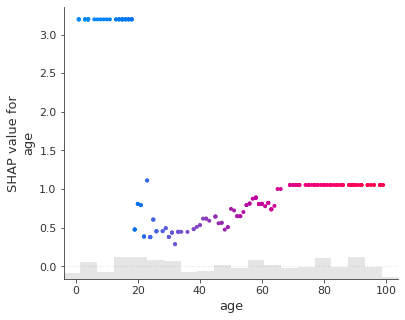

In [ ]:
# Partial Dependence Plot of concentration parameter
xgblss.plot(X_test,
            parameter="concentration",
            feature="age",
            plot_type="Partial_Dependence")

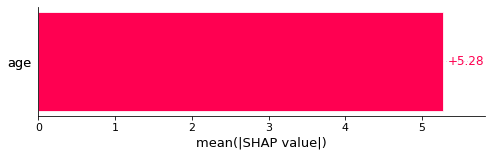

In [ ]:
# Feature Importance of gate parameter
xgblss.plot(X_test,
            parameter="gate",
            plot_type="Feature_Importance")

# Density Plots of Actual and Predicted Samples

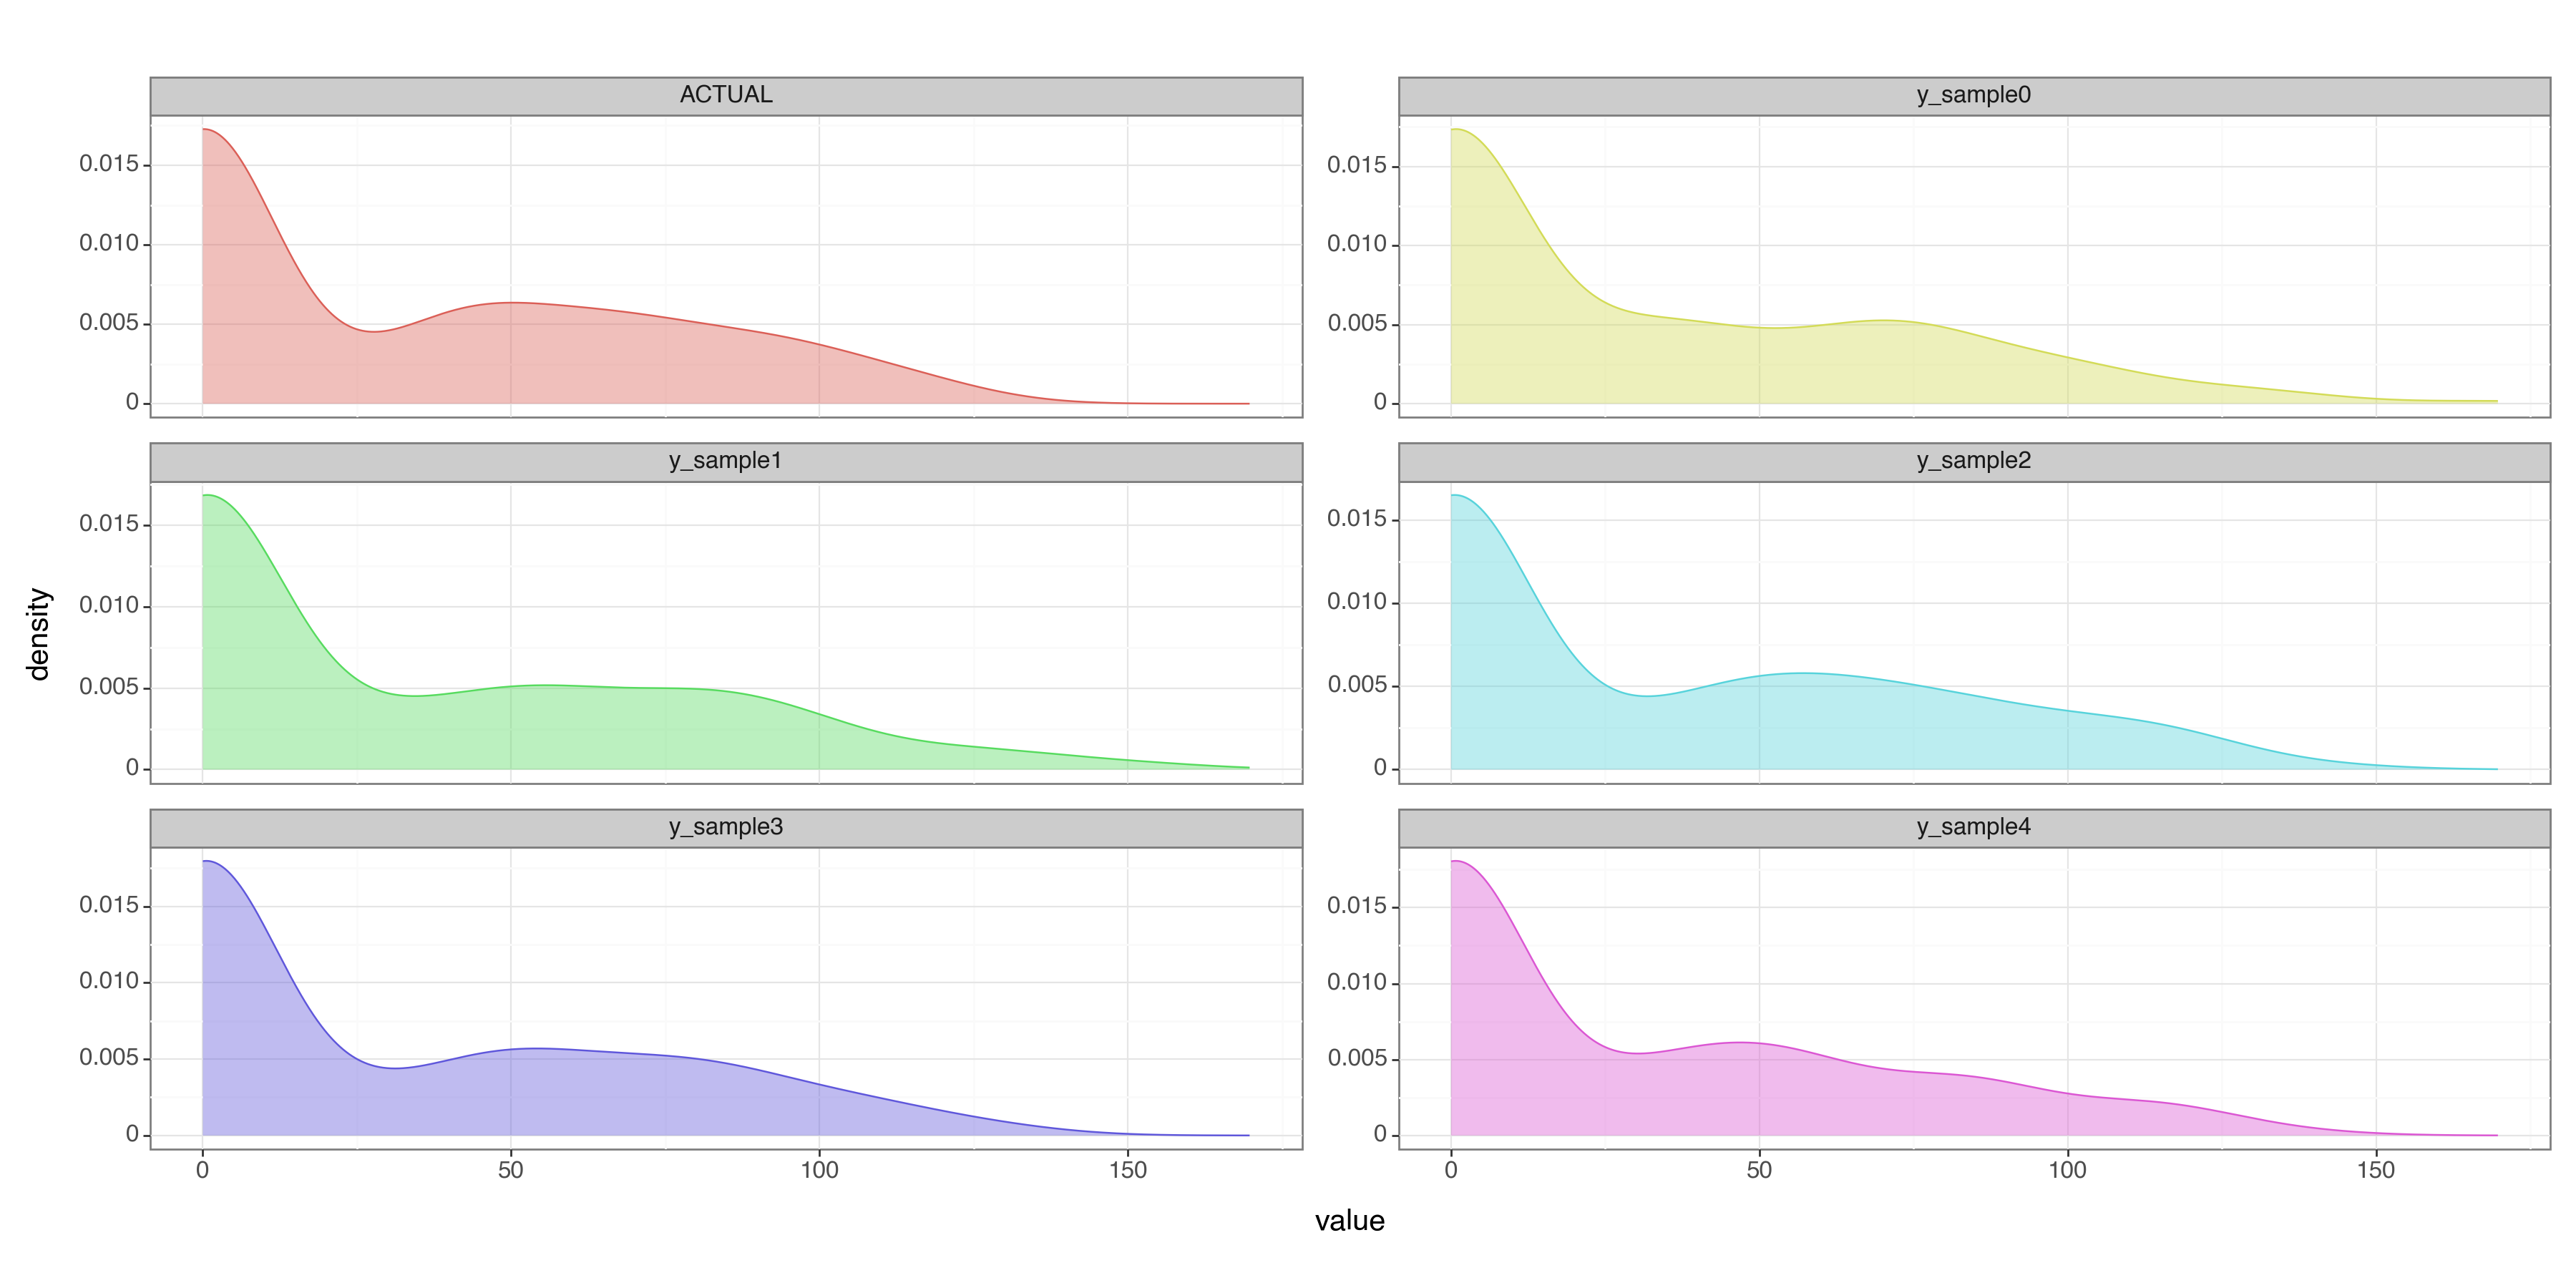

<Figure Size: (1800 x 900)>

In [ ]:
pred_df = pd.melt(pred_samples.iloc[:,0:5])
actual_df = pd.DataFrame.from_dict({"variable": "ACTUAL", "value": y_test.reshape(-1,)})
plot_df = pd.concat([pred_df, actual_df])

(
    ggplot(plot_df, 
           aes(x="value",
               color="variable",
               fill="variable")) +  
    geom_density(alpha=0.4) + 
    facet_wrap("variable",
              scales="free_y",
              ncol=2) + 
    theme_bw(base_size=15) + 
    theme(legend_position="none")
)